# **Mercedes Benz Greener Manufacturing**

##Business Problem

Kaggle Competition - Mercedes Benz Greener Manufacturing

The task of this competition by Daimler is to predict the time in seconds taken to pass the test for a given set of Mercedes-Benz car features, this helps the company in speedier testing and lower CO2 Emissions.

**Data Acquisition**

[https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data)

**Evaluation Metric**

Submissions for the competition is evaluated on R2 score. However as the  metric is directly related to mse we can directly optimize mse or rmse for that matter.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV   
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prettytable import PrettyTable
import pickle
from sklearn.model_selection import RepeatedKFold,KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from xgboost import plot_importance
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from scipy import stats
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_validate

Using TensorFlow backend.


In [0]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [0]:
random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train.csv')
results=  pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/sample_submission.csv')
y_train= train.y.values

In [0]:
cat_cols_0= train.columns[train.dtypes=="object"]#categorical columns
binary_cols_0= np.delete(train.columns[train.dtypes=="int64"],0)#binary columns
num_cols_0= train.columns[train.dtypes=="int64"]#numerical columns

### **Data Exploration**

In [0]:
train.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,0.007840,0.099549,0.142789,0.002613,0.086957,0.020670,0.001901,0.004989,0.682585,0.032549,0.043003,0.004514,0.232359,0.011167,0.000238,0.005464,0.232359,0.004514,0.232359,0.033262,0.000238,0.000713,0.011404,0.000238,0.072226,0.011404,0.253267,0.597292,0.012830,0.022333,...,0.022333,0.047517,0.0,0.947256,0.044904,0.338798,0.297220,0.054170,0.002138,0.202899,0.380375,0.179853,0.001188,0.426942,0.031837,0.076503,0.966025,0.520314,0.753861,0.002851,0.002851,0.001188,0.051794,0.062723,0.000475,0.006652,0.014255,0.000475,0.019244,0.227370,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,0.088208,0.299433,0.349899,0.051061,0.281805,0.142294,0.043561,0.070467,0.465526,0.177475,0.202888,0.067043,0.422387,0.105093,0.015414,0.073729,0.422387,0.067043,0.422387,0.179341,0.015414,0.026691,0.106192,0.015414,0.258893,0.106192,0.434934,0.490501,0.112552,0.147782,...,0.147782,0.212768,0.0,0.223549,0.207117,0.473357,0.457089,0.226379,0.046198,0.402205,0.485537,0.384110,0.034450,0.494693,0.175586,0.265832,0.181186,0.499647,0.430812,0.053325,0.053325,0.034450,0.221637,0.242492,0.021796,0.081300,0.118555,0.021796,0.137399,0.419183,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000

In [0]:
train.columns

Index(['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=378)

In [0]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


369 integer colums, 8 categorical columns

In [0]:
for col,k in zip(train.columns.tolist(),train.dtypes.tolist()):
  if k =='O':
    print(col +' : ',len(train[col].value_counts()))#cardinalities of various categorical variables

X0 :  47
X1 :  27
X2 :  44
X3 :  7
X4 :  4
X5 :  29
X6 :  12
X8 :  25


**Checking For Missing Values**

In [0]:
train.isnull().sum().sum()#No missing values

0

**Checking for Outliers**

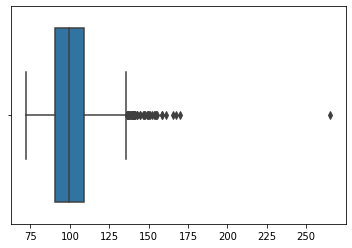

In [0]:
sns.boxplot(y_train)##presence of outliers clearly visible

Lot of Outliers atleast 20-30 of them can be seen here.

In [0]:
y_train.mean(),np.median(y_train)#mean being influenced by outliers

(100.66931812782134, 99.15)

In [0]:
#https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def reject_outliers(points, thresh = 3.5):
    """detects outliers based on modified z_score computed using median"""
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return points[modified_z_score > thresh]

In [0]:
outliers= reject_outliers(y_train)#so everything >=146.3 can be considered an outlier
print(outliers,min(outliers))

[[146.83]
 [150.43]
 [169.91]
 [154.87]
 [147.72]
 [265.32]
 [158.53]
 [154.43]
 [149.63]
 [160.87]
 [150.89]
 [152.32]
 [167.45]
 [154.16]
 [148.94]
 [158.23]
 [153.51]
 [147.22]
 [146.3 ]
 [165.52]
 [155.62]
 [149.52]] [146.3]


**Checking for Duplicate Rows with different Targets**

In [0]:
full= train
full['y']= y_train

In [0]:
duplicateRowsDF = full[full[[x for x in full.columns.tolist() if x != 'ID' and x!= 'y']].duplicated(keep= False)]
duplicateRowsDF.shape

(515, 378)

There are identical rows with different target variable values(515 rows)

**Checking for Duplicate Columns**

In [0]:
train_train = train.T.drop_duplicates().T
train_train.shape,train.shape

((4209, 322), (4209, 378))

56 columns which are constant throughout the trainset.

**Correlation Graph**

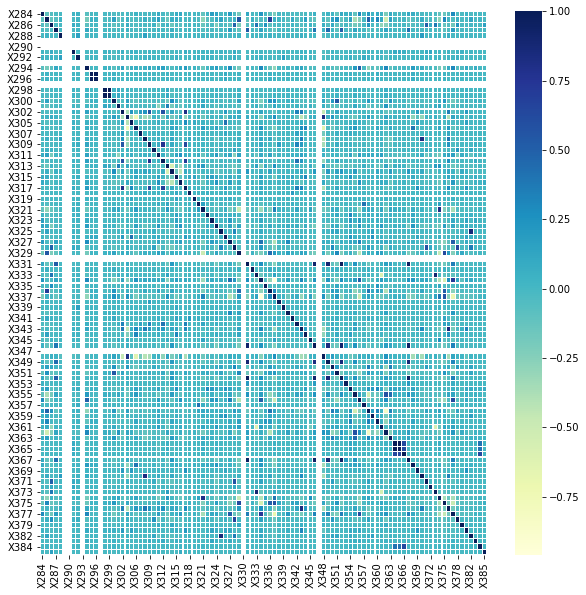

In [0]:
#https://www.geeksforgeeks.org/exploring-correlation-in-python/

corrmat = train.iloc[:,-100:].corr()#taking last 100 features  
  
f, ax = plt.subplots(figsize =(10, 10)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) #There are variables with 1 correlation coefficient

This shows some features having high correlation with other features.

In [0]:
cat_cols= train.columns[train.dtypes=="object"]#categorical columns
binary_cols= np.delete(train.columns[train.dtypes=="int64"],0,-1)#binary columns
num_cols= train.columns[train.dtypes=="int64"]#numerical columns

**Visualisation using PCA**

In [0]:
standardized_data = StandardScaler().fit_transform(train[binary_cols])
print(standardized_data.shape)
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)
print("shape of pca_reduced.shape = ", pca_data.shape)
pca_data = np.vstack((pca_data.T, y_train)).T

(4209, 368)
shape of pca_reduced.shape =  (4209, 2)


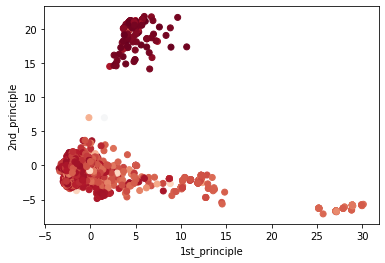

In [0]:
pca_df = pd.DataFrame(data=pca_data, columns=("1st", "2nd", "label"))
plt.scatter(pca_df['1st'],pca_df['2nd'], c=pca_df['label'], cmap="RdBu")
plt.xlabel('1st_principle')
plt.ylabel('2nd_principle')
plt.show()
#lets check if this observation really helps

PCA did find some good features lets try to check the mean and std of these clusters

In [0]:
#This can be reason in kaggle competition many kernels used pca with 6 components
#cluster1 mean,cluster2 mean,cluster3 mean
pca_df['label'][pca_df['2nd']>14].mean(),pca_df['label'][(pca_df['2nd']<14) & (pca_df['1st']<15)].mean(),pca_df['label'][(pca_df['2nd']<14) & (pca_df['1st']>15)].mean()

(77.96486187845298, 101.32426029486524, 116.97744680851063)

In [0]:
#cluster1 std,cluster2 std,cluster3 std
pca_df['label'][pca_df['2nd']>14].std(),pca_df['label'][(pca_df['2nd']<14) & (pca_df['1st']<15)].std(),pca_df['label'][(pca_df['2nd']<14) & (pca_df['1st']>15)].std()

(4.616846880686572, 11.80421638156366, 7.075507495179731)

Cluster 1 is very well seperated, but Cluster 2 which is fairly large is 1std away from Cluster 3.This surely can help the model but coming up with alternative ways is necessary to perform better.

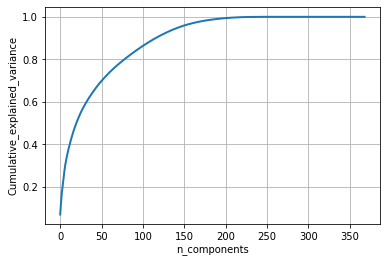

In [0]:
pca.n_components = 369
pca_data = pca.fit_transform(standardized_data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

Around 95% of variance is explained with about 150 components which is half the features given.

Here these things make sense from the above observations.

1.   PCA provides some useful features so including it in model will be useful.
2.   Duplicate rows with different target values can be replaced with mean or median.
3.   Outliers must be clipped off from the y_train, this may give overoptimistic results but atleast we can be sure that our CV and Private Leaderboard will be positively correlated.



**A look at best feature Correlations on Raw Data**

In [0]:
dic={}
for i in num_cols:
    if train[i].corr(train.y)>0.50 or train[i].corr(train.y)<-0.50:
      dic[i]=train[i].corr(train.y)
print("Important Features with there respective correlations are ",'\n','---------------------------------------------------------','\n',dic)

Important Features with there respective correlations are  
 --------------------------------------------------------- 
 {'X127': -0.5106197590551649, 'X261': 0.5887851610438137, 'X314': 0.6060052136703652}


**Removal of Features which are uninformative**

In [0]:
num_cols= num_cols_0

In [0]:
#Cleaning  up columns less than threshold variance.
rem_cols=[]
temp = []
for i in num_cols:
    if train[i].var()<=0.01:
        temp.append(i)
print(len(temp))
print(temp,'<0.01 variance columns')
rem_cols.extend(temp)

147
['X11', 'X15', 'X16', 'X17', 'X18', 'X21', 'X24', 'X26', 'X30', 'X33', 'X34', 'X36', 'X39', 'X40', 'X42', 'X53', 'X55', 'X59', 'X60', 'X62', 'X65', 'X67', 'X74', 'X78', 'X83', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X97', 'X99', 'X102', 'X104', 'X105', 'X107', 'X110', 'X112', 'X122', 'X123', 'X124', 'X125', 'X145', 'X153', 'X160', 'X165', 'X167', 'X169', 'X172', 'X173', 'X183', 'X184', 'X190', 'X192', 'X199', 'X200', 'X204', 'X205', 'X207', 'X210', 'X212', 'X213', 'X214', 'X216', 'X217', 'X221', 'X227', 'X230', 'X233', 'X235', 'X236', 'X237', 'X239', 'X240', 'X242', 'X243', 'X245', 'X248', 'X249', 'X252', 'X253', 'X254', 'X257', 'X258', 'X259', 'X260', 'X262', 'X266', 'X267', 'X268', 'X269', 'X270', 'X271', 'X274', 'X277', 'X278', 'X280', 'X281', 'X282', 'X288', 'X289', 'X290', 'X292', 'X293', 'X295', 'X296', 'X297', 'X298', 'X299', 'X307', 'X308', 'X309', 'X310', 'X312', 'X317', 'X318', 'X319', 'X320', 'X323', 'X325', 'X330', 'X332', 'X335', 'X338', 

In [0]:
#removing duplicate columns and leaving the original behind.
dups=list(train.T.index[train.T.duplicated(keep= 'first')].values)
print(dups)
rem_cols.extend(dups)

['X35', 'X37', 'X39', 'X76', 'X84', 'X93', 'X94', 'X102', 'X107', 'X113', 'X119', 'X122', 'X134', 'X146', 'X147', 'X172', 'X199', 'X213', 'X214', 'X216', 'X222', 'X226', 'X227', 'X232', 'X233', 'X235', 'X239', 'X242', 'X243', 'X244', 'X245', 'X247', 'X248', 'X253', 'X254', 'X262', 'X266', 'X268', 'X279', 'X289', 'X290', 'X293', 'X296', 'X297', 'X299', 'X302', 'X320', 'X324', 'X326', 'X330', 'X347', 'X360', 'X364', 'X365', 'X382', 'X385']


In [0]:
#X4 Found to have really low variance
train.X4.value_counts()

d    4205
a       2
b       1
c       1
Name: X4, dtype: int64

In [0]:
##################Removal of Uninformative Features Done Here
rem_cols= list(set(rem_cols))
rem_cols.append('X4')#only cat_col to be dropped
train= train.drop(rem_cols,axis=1)
test= test.drop(rem_cols,axis=1)
target= y_train
train.shape,test.shape

((4209, 211), (4209, 210))

### **Dataset Making**

**LabelEncoded Dataset**

In [0]:
#cats are label encoded here
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
                                    

train.y= np.clip(train.y.values,0,150) #clipping of y occurs here
test.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_label.csv',index= False)
train.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_label.csv',index= False)

In [0]:
train.head()

,ID,y,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,X14,X19,X20,X22,X23,X27,X28,X29,X31,X32,X38,X41,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X54,X56,X57,X58,X61,X63,...,X314,X315,X316,X321,X322,X327,X328,X329,X331,X333,X334,X336,X337,X340,X342,X343,X345,X346,X348,X349,X350,X351,X352,X354,X355,X356,X358,X359,X361,X362,X363,X367,X368,X371,X373,X374,X375,X376,X377,X378
0,0,130.81,37,23,20,0,27,9,14,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,6,88.53,37,21,22,4,31,11,14,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,7,76.26,24,24,38,2,30,9,23,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
3,9,80.62,24,21,38,5,30,11,4,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,14,3,13,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0


**Mean Encoded Dataset**

In [0]:
##cats are mean encoded here
y_mean= train.y.mean()
for col in cat_cols:
   y=train.groupby([col]).mean()['y']
   train[col]= [y.loc[a] for a in train[col]]
   test[col]=[(y.loc[a] if a in y.index else y_mean)for a in test[col]]
train.y= np.clip(train.y.values,0,150)
test.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_meanenc.csv',index= False)
train.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_meanenc.csv',index= False)

**Correlation of Categorical variables with Target**

In [0]:
for k in cat_cols:
  print(train[k].corr(train.y),'--->',k)

0.7782581671040522 ---> X0
0.21043301114505705 ---> X1
0.4906867003496653 ---> X2
0.21598114984670597 ---> X3
0.11900439734404482 ---> X5
0.10918048655236655 ---> X6
0.17187044046225866 ---> X8


Feature X0 is very well correlated to the target.

**OneHotEncoding Dataset**

In [0]:
##one_hot cats are created here.
from sklearn.preprocessing import OneHotEncoder
CC= OneHotEncoder(handle_unknown='ignore',sparse= False)
train_hot= pd.DataFrame(CC.fit_transform(train[cat_cols]),columns= ['hot_'+str(x) for x in range(191)])
test_hot= pd.DataFrame(CC.transform(test[cat_cols]),columns= ['hot_'+str(x) for x in range(191)])     
train=train.join(train_hot)
test=test.join(test_hot)
test.drop(cat_cols,axis=1,inplace= True)
train.drop(cat_cols,axis= 1,inplace= True)
print(train.shape)
train.y= np.clip(train.y.values,0,150)
test.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_hot.csv',index= False)
train.to_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_hot.csv',index= False)

(4209, 395)


### **Model Preperation**

CV was chosen to be RepeatedKFold with 5 folds with 3 repetitions.

In [0]:
cv= RepeatedKFold(n_splits= 5,n_repeats=3,random_state= random_seed)

**Baseline**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_label.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_label.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
cat_cols= [i for i in cat_cols_0 if i in train.columns] ##categorical columns
binary_cols= [i for i in binary_cols_0 if i in train.columns] #binary columns
num_cols= [i for i in num_cols_0 if i in train.columns ]#numerical columns

In [0]:
#https://www.kaggle.com/hakeem/stacked-then-averaged-models-0-5697
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# Add decomposed components: PCA / ICA etc.
n_comp = 12
ids_test = test.ID.values
# PCA
pca = PCA(n_components=n_comp, random_state=random_seed)

SS=StandardScaler()
pca_train= SS.fit_transform(train[num_cols])
pca_test= SS.transform(test[num_cols])                                         
pca2_results_train = pca.fit_transform(pca_train)
pca2_results_test = pca.transform(pca_test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:, i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

# Prepare data
X = np.array(train)
y = y_train
y_mean = np.mean(y)

X_test = np.array(test)

print('X.shape = ' + str(X.shape) + ', y.shape = ' + str(y.shape))
print('X_test.shape = ' + str(X.shape))

params = {}
params['n_trees'] = 500
params['objective'] = 'reg:linear'
params['eta'] = 0.005
params['max_depth'] = 3
params['subsample'] = 0.95
params['base_score'] = y_mean
params['silent'] = 1
params['n_thread']= -1
#params['colsample_bytree']= .9
xgb_r2_seal1 = []
test_preds_buf = []
d_test = xgb.DMatrix(X_test)

X.shape = (4209, 222), y.shape = (4209,)
X_test.shape = (4209, 222)


In [0]:
fold_i = 0
for train_index, test_index in cv.split(X):
    print('Fold #' + str(fold_i))
    x_train, x_valid, y_train, y_valid = X[train_index], X[test_index], y[train_index], y[test_index]

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)   

    print('XGB: Evaluating model')
    eval_set = [(x_train, y_train), (x_valid, y_valid)]
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    model = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, \
        feval=xgb_r2_score, maximize=True, verbose_eval=100)
        
    p = model.predict(d_valid)
    r2 = r2_score(y_valid, p)
    xgb_r2_seal1.append(r2)
    print('R2 = ' + str(r2))

    test_preds_buf.append(model.predict(d_test))

    fold_i += 1

print('XGB Mean R2 = ' + str(np.mean(xgb_r2_seal1)) + ' +/- ' + str(np.std(xgb_r2_seal1)))

print('XGB: Train on full dataset and predicting on test')
d_train = xgb.DMatrix(X, label=y)
watchlist = [(d_train, 'train')]
model = xgb.train(params, d_train, 700, watchlist, feval=xgb_r2_score, \
    maximize=True, verbose_eval=100)

p_test = model.predict(d_test)

test_preds_buf = np.array(test_preds_buf).T
test_preds_buf = np.concatenate((test_preds_buf, p_test.reshape((len(p_test),1))), axis=1)

subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = np.mean(test_preds_buf, axis=1)
subm.to_csv('xgb_pca12_15fold_16mdls.csv', index=False)

Fold #0
XGB: Evaluating model
[0]	train-rmse:12.3509	valid-rmse:12.0628	train-r2:0.005999	valid-r2:0.005397
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[100]	train-rmse:9.68992	valid-rmse:9.5898	train-r2:0.388175	valid-r2:0.371406
[200]	train-rmse:8.48776	valid-rmse:8.52492	train-r2:0.530568	valid-r2:0.503257
[300]	train-rmse:7.98084	valid-rmse:8.11952	train-r2:0.584966	valid-r2:0.549378
[400]	train-rmse:7.75116	valid-rmse:7.97747	train-r2:0.608511	valid-r2:0.565007
[500]	train-rmse:7.62515	valid-rmse:7.93269	train-r2:0.621137	valid-r2:0.569877
[600]	train-rmse:7.54012	valid-rmse:7.91998	train-r2:0.629539	valid-r2:0.571254
Stopping. Best iteration:
[640]	train-rmse:7.51233	valid-rmse:7.91823	train-r2:0.632264	valid-r2:0.571444

R2 = 0.5710785808510108
Fold #1
XGB: Evaluating model
[0]	train-rmse:12.3073	valid-rmse:12.2392	train-r2:0.005966	valid-r2:0.005873
Multiple eval metrics have been p

LB(.54638,56166)CV:(.6009)

SD of CV also produces as estimate as how well our folds are responding to these showing clipping of outliers clearly works.

**LR with OneHotEncoding Done Here**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_hot.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_hot.csv')
results=  pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/sample_submission.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
#using onehot on categorical columns,leaving binary columns as they are already normalized.
from sklearn.preprocessing import MinMaxScaler
ids_test= test.ID.values
SS=MinMaxScaler()
train['ID']=SS.fit_transform(train.ID.values.reshape(-1,1))
test['ID']= SS.transform(test.ID.values.reshape(-1,1))

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {'alpha':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3],'loss':['squared_loss']}
model= SGDRegressor(random_state= random_seed,penalty= 'l1')

clf = GridSearchCV(model, parameters, cv=cv, scoring='r2',verbose=1,return_train_score=True)
clf.fit(X, y)

print(clf.best_params_,clf.best_score_)

(4209, 394) X.shape
Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


{'alpha': 0.01, 'loss': 'squared_loss'} 0.5830251985845702


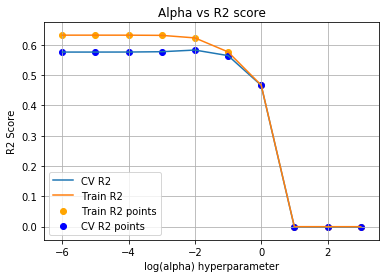

In [0]:
cv_r1= clf.cv_results_['mean_train_score']
cv_r2 = clf.cv_results_['mean_test_score']
plt.plot(np.log10(parameters['alpha']),cv_r2,label= 'CV R2')
plt.title('Alpha vs R2 score')
plt.xlabel('log(alpha) hyperparameter')
plt.ylabel('R2 Score')
plt.plot(np.log10(parameters['alpha']),cv_r1,label= 'Train R2')
plt.scatter(np.log10(parameters['alpha']),cv_r1,label= 'Train R2 points',color= 'orange')
plt.scatter(np.log10(parameters['alpha']),cv_r2,label= 'CV R2 points',color= 'blue')
plt.grid()
plt.legend()
plt.show()

In [0]:
model= SGDRegressor(**clf.best_params_,random_state= random_seed)
model.fit(X,y)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = model.predict(x_test)
subm.to_csv('lr_5folds.csv', index=False)

LB(0.53780,0.53253) cv:.58302

**Little t-test to check Importance of ID Feature**

In [0]:
cv1=RepeatedKFold(n_splits= 5,n_repeats= 50,random_state= random_seed)#250 folds
lr_id=cross_val_score(model,X,y,scoring='r2',cv= cv1,verbose=1,n_jobs=1)
lr_idless=cross_val_score(model,X[:,1:],y,scoring='r2',cv= cv1,verbose=1,n_jobs=1)#data with ID column removed

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.3min finished


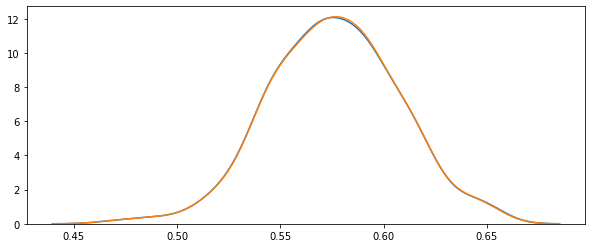

In [0]:
#https://machinelearningmastery.com/parametric-ue,axis=1)statistical-significance-tests-in-python/
plt.figure(figsize=(10,4))
sns.distplot(lr_id,hist= False)
sns.distplot(lr_idless,hist= False)

The gaussian distribution shows that t-test can be used for statistical significance testing.Lets try to check the null hypothesis that cv with ID and without ID are from same distribution.

In [0]:
#Now as the samples are not independent we have to use scipy.ttest_rel or Paired students t_test distribution.
stats.ttest_rel(lr_id,lr_idless)

Ttest_relResult(statistic=-1.7934487843033402, pvalue=0.07411461054366326)

This test concludes that with the training setup and CV that we have used ID and Not using them doesent make any difference.
Here we go out of what has been mentioned in kaggle kernels that ID Provided significant improvement as pvalue >.05 null hypothesis cant be rejected.
The reson can be that model was complex enough to make use of other features that ID becomes redundant.

**Mean Encoding for LR Done here**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_meanenc.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_meanenc.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
ids_test= test.ID.values
SS=MinMaxScaler()
train.iloc[:,:8]=SS.fit_transform(train.iloc[:,:8])#Id feature with all the cat variables are rescaled
test.iloc[:,:8]= SS.transform(test.iloc[:,:8])
x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {'alpha':[1e-1,1,1e1,1e-2,1e-3,1e-4],'loss':['squared_loss'],'penalty':['l1','l2']}
model= SGDRegressor(random_state= random_seed,)

clf = GridSearchCV(model, parameters, cv=cv, scoring='r2',verbose=1)
clf.fit(X, y)

print(clf.best_params_,clf.best_score_)

(4209, 210) X.shape
Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   47.3s finished


{'alpha': 0.01, 'loss': 'squared_loss', 'penalty': 'l1'} 0.5838024669319191


In [0]:
model= SGDRegressor(**clf.best_params_,random_state= random_seed)
model.fit(X,y)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = model.predict(x_test)
subm.to_csv('lr_5folds_meanenc.csv', index=False)

LB(0.53792,0.54382)CV:.58380

**MeanEncoding Done Here for RandomForestRegressor**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_meanenc.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_meanenc.csv')

y_train= train.y.values
targets= y_train.copy()
train.drop(['y'],inplace= True,axis=1)

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[600],
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [5],#[1,2,3,4,5,6],#[3,4,5,6,7],
              "max_features": [.95],
             'min_impurity_decrease':[1e-2],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= RandomForestRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

(4209, 210) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.9s finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 5, 'n_estimators': 600}


In [0]:
rf_tar= RandomForestRegressor(**clf.best_params_,random_state= random_seed,oob_score= True)
rf_tar.fit(X,y)
print('oob_score: ',rf_tar.oob_score_)
cv_score=cross_val_score(rf_tar,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = rf_tar.predict(x_test)
subm.to_csv('rf_5folds_meanenc.csv', index=False)

oob_score:  0.6054807310827848


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6055514389987438  +/-  0.022463458244656155


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.6min finished


LB(0.54897,0.55864),CV:.6055

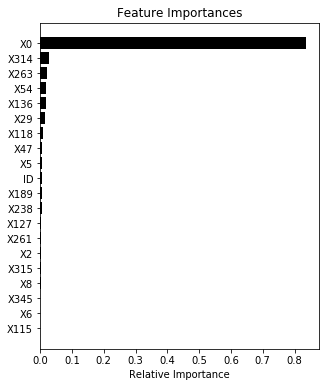

In [0]:
features = train.columns
importances = rf_tar.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(5,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**MeanEncoding Using XGBoost**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_meanenc.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_meanenc.csv')

y_train= train.y.values
targets= y_train.copy()
train.drop(['y'],inplace= True,axis=1)

In [0]:
cv3= KFold(5,True,random_seed)
parameters= {'learning_rate': [0.05],
               'subsample': [.72],#[.9,.8,.7,.6,.5,1], 
               'colsample_bytree': [.72],#[.9,.8,.7,.6,.5,1],#[.8],#[0.8,.85]
               'min_child_weight':[10],#[10,20,30,50,100,150,200], #[1,5,10],#[110,120,130]
               'max_depth': [2],#[2,4,6,10], 
               'n_estimators':[151],
               'verbosity':[1],
             'gamma':[.01],#[1e-2,1e-3,1e-4,0,.1,.2,.3,.4,.5,1,3,5,10],
             'reg_alpha':[1],#[1e-5,1e-3,1e-1,1,1e1,1e2]
             
             }
model= xgb.XGBRegressor(n_jobs=1,random_state= random_seed,verbosity=1,silent=True)
clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


{'colsample_bytree': 0.72, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 151, 'reg_alpha': 1, 'subsample': 0.72, 'verbosity': 1}


In [0]:
xgb_tar= xgb.XGBRegressor(**clf.best_params_,random_state= random_seed,silent=True)
X_lab= pd.DataFrame(X,columns= train.columns)
x_test_lab=pd.DataFrame(x_test,columns= train.columns) 
xgb_tar.fit(X_lab,y)
cv_score=cross_val_score(xgb_tar,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = xgb_tar.predict(x_test_lab)
subm.to_csv('xgb_meanenc.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6081670903478663  +/-  0.02161144780988898


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   27.3s finished


LB(0.54832,0.55701)CV:.60816

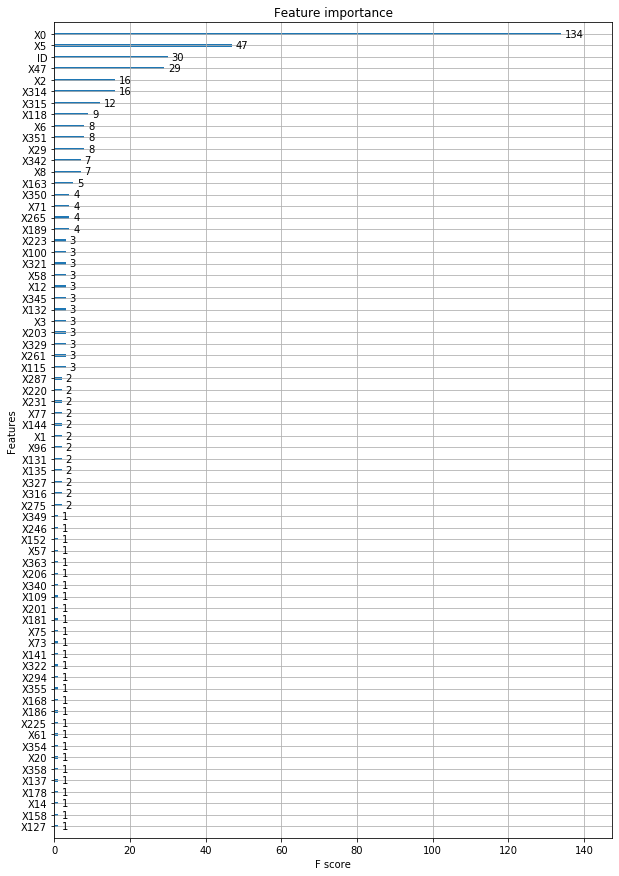

In [0]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(xgb_mean,max_num_features= 70, ax=ax)
plt.show()

**MeanEncoding on ExtraTreesRegressor**

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[750],#range(700,1500,50),
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [10],#[3,4,5,6,7],
              "max_features": [.95],#[.95],
             'min_impurity_decrease':[1e-4],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= ExtraTreesRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


(4209, 210) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 10, 'n_estimators': 750}


In [0]:
et_tar= ExtraTreesRegressor(**clf.best_params_,random_state= random_seed,oob_score= True,bootstrap= True)
et_tar.fit(X,y)
print('oob_score: ',et_tar.oob_score_)
cv_score=cross_val_score(et_tar,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = et_tar.predict(x_test)
subm.to_csv('et_5folds_meanenc.csv', index=False)

oob_score:  0.6030986205377533


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6009667986911981  +/-  0.021531916778920388


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.4min finished


LB(0.54831,0.55545),CV:.60096

**Random Forest Regressor LabelEncoding**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_label.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_label.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[600],
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [5],#[1,2,3,4,5,6],#[3,4,5,6,7],
              "max_features": [.95],
             'min_impurity_decrease':[1e-2],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= RandomForestRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

(4209, 210) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 5, 'n_estimators': 600}


In [0]:
rf_label= RandomForestRegressor(**clf.best_params_,random_state= random_seed,oob_score= True)
rf_label.fit(X,y)
print('oob_score: ',rf_label.oob_score_)
cv_score=cross_val_score(rf_label,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = rf_label.predict(x_test)
subm.to_csv('rf_5folds_label.csv', index=False)

oob_score:  0.6022263656601465


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6023986685575103  +/-  0.02119851269797542


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.5min finished


LB(0.54986,0.55686),CV:.6023

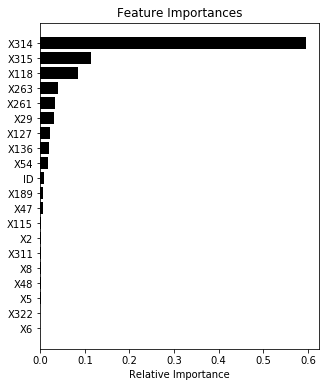

In [0]:
features = train.columns
importances = rf_label.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(5,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Xgboost with LabelEncoding**

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {'learning_rate': [0.05],
               'subsample': [.72],#[.9,.8,.7,.6,.5,1], 
               'colsample_bytree': [.72],#[.9,.8,.7,.6,.5,1],#[.8],#[0.8,.85]
               'min_child_weight':[10],#[10,20,30,50,100,150,200], #[1,5,10],#[110,120,130]
               'max_depth': [2],#[2,4,6,10], 
               'n_estimators':[151],
               'verbosity':[1],
             'gamma':[.01],#[1e-2,1e-3,1e-4,0,.1,.2,.3,.4,.5,1,3,5,10],
             'reg_alpha':[1],#[1e-5,1e-3,1e-1,1,1e1,1e2]
             
             }
model= xgb.XGBRegressor(n_jobs=1,random_state= random_seed,verbosity=1,silent=True)
clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


(4209, 210) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


{'colsample_bytree': 0.72, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 151, 'reg_alpha': 1, 'subsample': 0.72, 'verbosity': 1}


In [0]:
xgb_lab= xgb.XGBRegressor(**clf.best_params_,random_state= random_seed,silent=True)
X_lab= pd.DataFrame(X,columns= train.columns)
x_test_lab=pd.DataFrame(x_test,columns= train.columns)
xgb_lab.fit(X_lab,y)
cv_score=cross_val_score(xgb_lab,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = xgb_lab.predict(x_test_lab)
subm.to_csv('xgb_meanenc.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6042210150371721  +/-  0.021417573272027906


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.6s finished


LB(0.55034,0.55555)CV:.60422

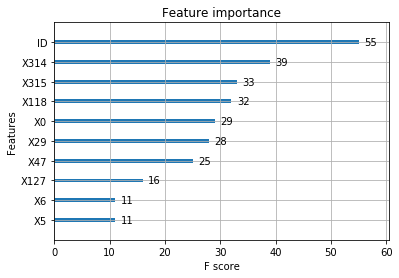

In [0]:
plot_importance(xgb_lab,max_num_features= 10)

**ExtraTrees Regressor LabelEncoding**

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[350],#range(50,600,50),
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [10],#[3,4,5,6,7],
              "max_features": [.95],#[.95],
             'min_impurity_decrease':[1e-4],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= ExtraTreesRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


(4209, 210) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.9s finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 10, 'n_estimators': 350}


In [0]:
et_lab= ExtraTreesRegressor(**clf.best_params_,random_state= random_seed,oob_score= True,bootstrap= True)
et_lab.fit(X,y)
print('oob_score: ',et_lab.oob_score_)
cv_score=cross_val_score(et_lab,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = et_lab.predict(x_test)
subm.to_csv('et_5folds_label.csv', index=False)

oob_score:  0.6010326127840766


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5986308922513477  +/-  0.021121052286242285


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


LB(0.54703,0.55379),CV:.59863

**Stacking all the models trained on LabelEncoded dataset**

In [0]:
ridge= Ridge(random_state=random_seed,fit_intercept= False,alpha=0)
stack = StackingCVRegressor(regressors=(rf_label, xgb_lab,et_lab),
                            meta_regressor=ridge, 
                            use_features_in_secondary=False,refit=True,cv=cv)

cv_score=cross_val_score(stack,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())
stack.fit(X,y)
ids_test= test.ID
y_pred = stack.predict(x_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('submission_xgb_rf_stack_ridge_label.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 43.7min finished


0.6052152518324975  +/-  0.02131608341482325


LB(.55226,.55790),CV:.60521

**Using Feature Interactions**

In [0]:
#https://www.kaggle.com/qqgeogor/some-feature-engineering
from scipy.stats import spearmanr
sum_cols = []
for c in binary_cols:
    score = (spearmanr(y,train[c]))
    if score[0]>=0.2 and score[0]<=0.3:
        print(c,score)
        sum_cols.append(c)

train['sum_row_2_to_3'] = train.drop('ID', axis=1)[sum_cols].sum(axis=1)
test['sum_row_2_to_3'] = test.drop('ID', axis=1)[sum_cols].sum(axis=1)

X14 SpearmanrResult(correlation=0.23271473847676327, pvalue=7.203142355334819e-53)
X48 SpearmanrResult(correlation=0.20357136242667562, pvalue=1.2996316630463163e-40)
X51 SpearmanrResult(correlation=0.2611121293074829, pvalue=1.4523427512271017e-66)
X66 SpearmanrResult(correlation=0.21315968127467158, pvalue=1.8967188268459342e-44)
X118 SpearmanrResult(correlation=0.27090253163947037, pvalue=1.0602732360517293e-71)
X126 SpearmanrResult(correlation=0.2417200374417423, pvalue=5.073645605858001e-57)
X130 SpearmanrResult(correlation=0.23415409276582105, pvalue=1.6054566396772044e-53)
X179 SpearmanrResult(correlation=0.2366639405029322, pvalue=1.1432996184544922e-54)
X191 SpearmanrResult(correlation=0.2296580095236195, pvalue=1.687603773776457e-51)
X198 SpearmanrResult(correlation=0.2055358155294325, pvalue=2.2052011207271959e-41)
X223 SpearmanrResult(correlation=0.22158801608519174, pvalue=5.595741666819109e-48)
X224 SpearmanrResult(correlation=0.2202985852333516, pvalue=1.9842662148088542

In [0]:
print('feature 2')
sum_cols = []
for c in binary_cols:
    score = (spearmanr(y,train[c]))
    if score[0]>=0.1 and score[0]<=0.2:
        print(c,score)
        sum_cols.append(c)

train['sum_row_1_to_2'] = train.drop('ID', axis=1)[sum_cols].sum(axis=1)
test['sum_row_1_to_2'] = test.drop('ID', axis=1)[sum_cols].sum(axis=1)

feature 2
X47 SpearmanrResult(correlation=0.12128833484321079, pvalue=2.8886024870257605e-15)
X52 SpearmanrResult(correlation=0.1973661460541078, pvalue=3.12675244238439e-38)
X64 SpearmanrResult(correlation=0.1018128914475367, pvalue=3.578824433646211e-11)
X68 SpearmanrResult(correlation=0.1620006747077727, pvalue=3.8136608908043135e-26)
X71 SpearmanrResult(correlation=0.1488980228079688, pvalue=2.697699163541339e-22)
X75 SpearmanrResult(correlation=0.15457622673680788, pvalue=6.364261721190012e-24)
X85 SpearmanrResult(correlation=0.12812999370557837, pvalue=7.144875915703804e-17)
X96 SpearmanrResult(correlation=0.15027972692024613, pvalue=1.09846238933138e-22)
X150 SpearmanrResult(correlation=0.158286007669749, pvalue=5.090255968583112e-25)
X151 SpearmanrResult(correlation=0.10641844916400506, pvalue=4.462529252730155e-12)
X155 SpearmanrResult(correlation=0.1324120072574912, pvalue=6.357836342267669e-18)
X156 SpearmanrResult(correlation=0.15733524644002178, pvalue=9.782389408056896e-2

In [0]:
print('feature 3')
sum_cols = []
for c in binary_cols:
    score = (spearmanr(y,train[c]))
    if score[0]>=0.05 and score[0]<=0.1:
        print(c,score)
        sum_cols.append(c)

train['sum_row_05_to_1'] = train.drop('ID', axis=1)[sum_cols].sum(axis=1)
test['sum_row_05_to_1'] = test.drop('ID', axis=1)[sum_cols].sum(axis=1)

feature 3
X12 SpearmanrResult(correlation=0.08803722235600211, pvalue=1.0590641386771599e-08)
X13 SpearmanrResult(correlation=0.051707750072676674, pvalue=0.0007911225065559363)
X44 SpearmanrResult(correlation=0.09077275830914208, pvalue=3.6465001055743447e-09)
X69 SpearmanrResult(correlation=0.08971114020696344, pvalue=5.536034403876071e-09)
X82 SpearmanrResult(correlation=0.053643507285088814, pvalue=0.0004982552551932894)
X109 SpearmanrResult(correlation=0.0745623704890028, pvalue=1.281036881645429e-06)
X131 SpearmanrResult(correlation=0.07308723350648445, pvalue=2.068575956661907e-06)
X142 SpearmanrResult(correlation=0.08659647934328635, pvalue=1.8336344983701157e-08)
X163 SpearmanrResult(correlation=0.06583065125948522, pvalue=1.9178121894735077e-05)
X171 SpearmanrResult(correlation=0.08929405917188903, pvalue=6.5143701262795555e-09)
X176 SpearmanrResult(correlation=0.05596658896258349, pvalue=0.0002804684439862748)
X177 SpearmanrResult(correlation=0.05371222547262586, pvalue=0.00

**Interactions Included**

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[600],
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [5],#[1,2,3,4,5,6],#[3,4,5,6,7],
              "max_features": [.95],
             'min_impurity_decrease':[1e-2],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= RandomForestRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)
rf_label= RandomForestRegressor(**clf.best_params_,random_state= random_seed,oob_score= True)
rf_label.fit(X,y)
print('oob_score: ',rf_label.oob_score_)

(4209, 213) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 5, 'n_estimators': 600}
oob_score:  0.6021561663055823


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6022266021009817  +/-  0.021248052108807296


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.6min finished


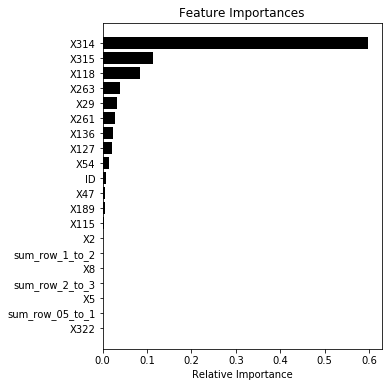

In [0]:
features = train.columns
importances = rf_label.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(5,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

new features found have got a place in the feature importance chart

In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {'learning_rate': [0.05],
               'subsample': [.72],#[.9,.8,.7,.6,.5,1], 
               'colsample_bytree': [.72],#[.9,.8,.7,.6,.5,1],#[.8],#[0.8,.85]
               'min_child_weight':[10],#[10,20,30,50,100,150,200], #[1,5,10],#[110,120,130]
               'max_depth': [2],#[2,4,6,10], 
               'n_estimators':[151],
               'verbosity':[1],
             'gamma':[.01],#[1e-2,1e-3,1e-4,0,.1,.2,.3,.4,.5,1,3,5,10],
             'reg_alpha':[1],#[1e-5,1e-3,1e-1,1,1e1,1e2]
             
             }
model= xgb.XGBRegressor(n_jobs=1,random_state= random_seed,verbosity=1,silent=True)
clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)
xgb_lab= xgb.XGBRegressor(**clf.best_params_,random_state= random_seed,silent=True)
X_lab= pd.DataFrame(X,columns= train.columns)
x_test_lab=pd.DataFrame(x_test,columns= train.columns)
xgb_lab.fit(X_lab,y)

(4209, 213) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


{'colsample_bytree': 0.72, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 151, 'reg_alpha': 1, 'subsample': 0.72, 'verbosity': 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6033413557227743  +/-  0.02117461279342622


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.8s finished


In [0]:
cv3= KFold(5,True,random_seed)
y_mean= y_train.mean()

x_test= np.array(test)
X= np.array(train)
y= targets
print(X.shape,'X.shape')
parameters= {"n_estimators":[350],#range(50,600,50),
              "max_depth": [4],#[3,4,5,6,7,8,9,10],#list(range(2,10)),#4 is the best
              "min_samples_leaf": [10],#[3,4,5,6,7],
              "max_features": [.95],#[.95],
             'min_impurity_decrease':[1e-4],#[1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
              }
model= ExtraTreesRegressor(n_jobs=1,random_state= random_seed)

clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(X, y)

ids_test= test.ID.values
print(clf.best_params_)
et_lab= ExtraTreesRegressor(**clf.best_params_,random_state= random_seed,oob_score= True,bootstrap= True)
et_lab.fit(X,y)
print('oob_score: ',et_lab.oob_score_)

(4209, 213) X.shape
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s finished


{'max_depth': 4, 'max_features': 0.95, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 10, 'n_estimators': 350}
oob_score:  0.6008159716945323


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5986564267097183  +/-  0.021069775384546185


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


In [0]:
ridge= Ridge(random_state=random_seed,fit_intercept= False,alpha=0)
stack = StackingCVRegressor(regressors=(rf_label, xgb_lab,et_lab),
                            meta_regressor=ridge, 
                            use_features_in_secondary=False,refit=True,cv=cv)

cv_score=cross_val_score(stack,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())
stack.fit(X,y)
ids_test= test.ID
y_pred = stack.predict(x_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('submission_xgb_rf_stack_ridge_label.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 45.1min finished


0.6044614316044898  +/-  0.021252431513073353


LB(.55196,.55743),CV:.60446

cv got worse along with other feature interactions than before, so including the best model without any feature interactions for inference.

**SVR WITH TSVD**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_hot.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_hot.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)
print(train.shape)

(4209, 394)


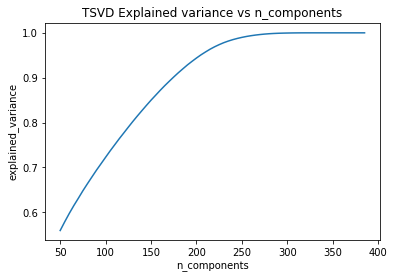

In [0]:
x=[]
y=[]
SS= StandardScaler()
svd_train=SS.fit_transform(train)
svd_test= SS.transform(test)
for i in range(50,390,5):
  tsvd= TruncatedSVD(i,random_state= random_seed)
  _= tsvd.fit_transform(svd_train)
  x.append(i)
  y.append(sum(tsvd.explained_variance_ratio_))
plt.plot(x,y)
plt.ylabel('explained_variance')
plt.xlabel('n_components')
plt.title('TSVD Explained variance vs n_components')
tsvd= TruncatedSVD(230,random_state= random_seed)#elbow between 250,200
svd_train= tsvd.fit_transform(svd_train)
svd_test= tsvd.transform(svd_test)

In [0]:
for c in [.04]:#[.01,.02,.03,.04,.05,.06,.1,]:#[1e-3,1e-2,1e-1,1]:
  svr= SGDRegressor(loss= 'epsilon_insensitive',alpha= c,penalty= 'elasticnet',random_state= random_seed)
  print(c)
  cv_score=cross_val_score(svr,svd_train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
  print(cv_score.mean(),' +/- ',cv_score.std())
  svr.fit(svd_train,targets)
  ids_test= test.ID
  y_pred = svr.predict(svd_test)
  subm = pd.DataFrame()
  subm['ID'] = ids_test
  subm['y'] = y_pred
  subm.to_csv('svr_tsvd.csv', index=False)

0.04


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.4s finished


0.5567327921982091  +/-  0.02028322537034436


LB(.5021,.5157),CV:.5567

**Kernel SVM**

In [0]:
cv3= KFold(5,True,random_seed)
model= SVR()
parameters={'kernel':['poly'],'degree':[2,3,4,5],'C':[1e-1,1,1e1,1e2,1e3]}
clf = GridSearchCV(model, parameters, cv=cv3, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(svd_train, targets)
print(clf.best_score_,clf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished


0.5192986687896454 {'C': 10.0, 'degree': 2, 'kernel': 'poly'}


In [0]:
from sklearn.svm import SVR

cv3= KFold(5,True,random_seed)
model= SVR()
parameters={'kernel':['rbf'],'C':[1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}
clf = GridSearchCV(model, parameters, cv=cv, scoring='r2',
                         verbose=1,return_train_score= True,n_jobs=-1)
clf.fit(svd_train, targets)
print(clf.best_score_)

Fitting 15 folds for each of 7 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 10.9min finished


0.5368236466098156


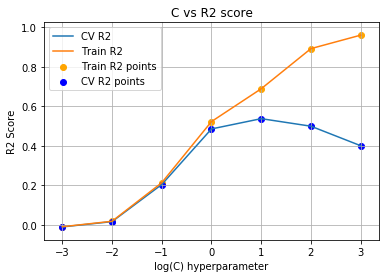

In [0]:
cv_r1= clf.cv_results_['mean_train_score']
cv_r2 = clf.cv_results_['mean_test_score']
plt.plot(np.log10(parameters['C']),cv_r2,label= 'CV R2')
plt.title('C vs R2 score')
plt.xlabel('log(C) hyperparameter')
plt.ylabel('R2 Score')
plt.plot(np.log10(parameters['C']),cv_r1,label= 'Train R2')
plt.scatter(np.log10(parameters['C']),cv_r1,label= 'Train R2 points',color= 'orange')
plt.scatter(np.log10(parameters['C']),cv_r2,label= 'CV R2 points',color= 'blue')
plt.grid()
plt.legend()
plt.show()

In [0]:
svr= SVR(**{'C':10,'kernel':'rbf'})##using rbf

In [0]:
cv_score=cross_val_score(svr,svd_train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())
svr.fit(svd_train,targets)
ids_test= test.ID

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   57.2s finished


0.5368236466098156  +/-  0.02336082835882139


Linear SVM worked better than kernels SVM.

**SVR WITH SELECTKBEST**

In [0]:
#Centering of data done before fitting to a  LinearModel
SS= StandardScaler()
ss_train=SS.fit_transform(train)
ss_test= SS.transform(test)
skbest= SelectKBest(f_regression,k=230)
skbest_train=skbest.fit_transform(ss_train,targets)
skbest_test=skbest.transform(ss_test)
svr= SGDRegressor(loss= 'epsilon_insensitive',alpha= .04,penalty= 'elasticnet',random_state= random_seed)
svr.fit(skbest_train,targets)
cv_score=cross_val_score(svr,skbest_train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.5633626352641173  +/-  0.02062498588462952


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.3s finished


In [0]:
ids_test= test.ID
y_pred = svr.predict(skbest_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('skbest_150.csv', index=False)

LB(0.50797,0.51673),CV:.5639

### **Bayesian Optimisation**

#### **Label Encoding**

**RandomForest BayesianTuning**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_label.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_label.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
#https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
def rf_evaluate(n_estimators,max_depth,min_samples_leaf,max_features,min_impurity_decrease):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_samples_leaf':int(min_samples_leaf),
          'min_impurity_decrease':min_impurity_decrease,
          'max_features':max_features
          }
  rf_label= RandomForestRegressor(**params)
  cv_score=cross_val_score(rf_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [0]:
rf_bo= BayesianOptimization(rf_evaluate,{'n_estimators':(550,650),
          'max_depth':(1,5),
          'min_samples_leaf':(1,7),
          'min_impurity_decrease':(.001,1),
          'max_features':(.5,1)
          })
rf_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.5985   |  4.435    |  0.6865   |  0.5557   |  1.367    |  617.7    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.5965   |  3.487    |  0.5462   |  0.07859  |  4.351    |  578.8    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.3906   |  1.377    |  0.7204   |  0.8453   |  4.818    |  638.2    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.5587   |  2.553    |  0.8821   |  0.9798   |  2.795    |  558.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.5975   |  3.71     |  0.5985   |  0.1878   |  1.793    |  630.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.3888   |  1.823    |  0.9155   |  0.08812  |  3.893    |  621.7    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.5604   |  2.816    |  0.7506   |  0.191    |  3.589    |  606.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.5972   |  4.639    |  0.9006   |  0.6443   |  1.855    |  600.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.3889   |  1.892    |  0.8648   |  0.8162   |  6.142    |  635.9    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.8s finished


|  10       |  0.3986   |  1.94     |  0.5018   |  0.2839   |  4.127    |  555.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished


|  11       |  0.6019   |  4.763    |  0.5455   |  0.006589 |  1.112    |  649.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s finished


|  12       |  0.3893   |  1.0      |  1.0      |  1.0      |  1.0      |  570.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.3s finished


|  13       |  0.5958   |  5.0      |  1.0      |  1.0      |  7.0      |  566.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.9s finished


|  14       |  0.596    |  5.0      |  1.0      |  1.0      |  7.0      |  590.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.7s finished


|  15       |  0.5997   |  4.951    |  0.7691   |  0.456    |  1.085    |  551.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.1s finished


|  16       |  0.6037   |  5.0      |  0.5      |  0.001    |  1.0      |  562.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.0s finished


|  17       |  0.5958   |  5.0      |  1.0      |  1.0      |  7.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.7s finished


|  18       |  0.5953   |  5.0      |  1.0      |  1.0      |  1.0      |  584.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished


|  19       |  0.6023   |  5.0      |  0.5      |  0.001    |  7.0      |  609.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.9s finished


|  20       |  0.6034   |  5.0      |  0.5      |  0.001    |  1.0      |  638.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.7s finished


|  21       |  0.5959   |  5.0      |  1.0      |  1.0      |  7.0      |  579.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s finished


|  22       |  0.3993   |  1.0      |  0.5      |  0.001    |  1.0      |  591.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.1s finished


|  23       |  0.6006   |  5.0      |  1.0      |  0.001    |  1.0      |  609.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.1s finished


|  24       |  0.5955   |  5.0      |  1.0      |  1.0      |  1.0      |  626.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.3s finished


|  25       |  0.6029   |  5.0      |  0.5      |  0.001    |  7.0      |  600.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.0s finished


|  26       |  0.596    |  4.975    |  0.9703   |  0.9464   |  6.898    |  556.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.6s finished


|  27       |  0.5952   |  5.0      |  1.0      |  1.0      |  1.0      |  557.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.3s finished


|  28       |  0.5971   |  4.726    |  0.814    |  0.7847   |  6.196    |  550.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished


|  29       |  0.3997   |  1.0      |  0.5      |  1.0      |  1.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished


|  30       |  0.3903   |  1.074    |  0.7483   |  0.975    |  6.985    |  583.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.4s finished


|  31       |  0.5962   |  5.0      |  0.5      |  1.0      |  1.0      |  576.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.7s finished


|  32       |  0.6026   |  5.0      |  0.5      |  0.001    |  7.0      |  644.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s finished


|  33       |  0.6026   |  5.0      |  0.5      |  0.001    |  6.047    |  584.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.8s finished


|  34       |  0.5958   |  5.0      |  0.5      |  1.0      |  4.259    |  561.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s finished


|  35       |  0.6012   |  5.0      |  1.0      |  0.001    |  1.0      |  579.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.9s finished


|  36       |  0.6025   |  5.0      |  0.5      |  0.001    |  7.0      |  627.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s finished


|  37       |  0.6036   |  5.0      |  0.5      |  0.001    |  1.0      |  593.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.1s finished


|  38       |  0.5955   |  5.0      |  0.5      |  1.0      |  7.0      |  616.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.0s finished


|  39       |  0.6024   |  5.0      |  0.5      |  0.001    |  7.0      |  573.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s finished


|  40       |  0.3892   |  1.0      |  1.0      |  1.0      |  1.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.9s finished


|  41       |  0.6037   |  5.0      |  0.5      |  0.001    |  1.0      |  632.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.3s finished


|  42       |  0.5954   |  5.0      |  1.0      |  1.0      |  1.0      |  644.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.0s finished


|  43       |  0.5962   |  5.0      |  0.5      |  1.0      |  1.0      |  612.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.8s finished


|  44       |  0.5954   |  5.0      |  1.0      |  1.0      |  1.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.0s finished


|  45       |  0.6032   |  5.0      |  0.5      |  0.001    |  1.0      |  622.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.0s finished


|  46       |  0.5958   |  5.0      |  1.0      |  1.0      |  5.334    |  605.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished


|  47       |  0.6013   |  5.0      |  0.5      |  0.001    |  3.892    |  614.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.9s finished


|  48       |  0.6034   |  5.0      |  0.5      |  0.001    |  1.0      |  604.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.6s finished


|  49       |  0.6029   |  5.0      |  1.0      |  0.001    |  7.0      |  561.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.2s finished


|  50       |  0.6002   |  5.0      |  1.0      |  0.001    |  3.759    |  574.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished


|  51       |  0.5957   |  5.0      |  0.5      |  1.0      |  4.239    |  630.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  52       |  0.6016   |  5.0      |  1.0      |  0.001    |  4.183    |  647.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.4s finished


|  53       |  0.6029   |  5.0      |  1.0      |  0.001    |  7.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s finished


|  54       |  0.596    |  5.0      |  0.5      |  1.0      |  4.505    |  595.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.3s finished


|  55       |  0.603    |  5.0      |  0.5      |  0.001    |  1.0      |  644.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.6s finished


|  56       |  0.389    |  1.063    |  0.9292   |  0.05271  |  1.065    |  562.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.2s finished


|  57       |  0.5958   |  5.0      |  0.5      |  1.0      |  3.456    |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.2s finished


|  58       |  0.3892   |  1.221    |  0.9858   |  0.4283   |  6.881    |  600.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.0s finished


|  59       |  0.6014   |  5.0      |  1.0      |  0.001    |  4.114    |  590.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.6029   |  5.0      |  1.0      |  0.001    |  7.0      |  639.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [0]:
rf_bo.max

{'params': {'max_depth': 5.0,
  'max_features': 0.5,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 1.0,
  'n_estimators': 632.1540758277154},
 'target': 0.6037271160271158}

CV improved by .014 than the manually tuned model.

In [0]:
rf_label= RandomForestRegressor(**{'max_depth': 5,'max_features': 0.5,'min_impurity_decrease': 0.001,'min_samples_leaf': 1,'n_estimators': 632},random_state= random_seed,oob_score= True)
rf_label.fit(train,targets)
print('oob_score: ',rf_label.oob_score_)
cv_score=cross_val_score(rf_label,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = rf_label.predict(test)
subm.to_csv('rf_5folds_label.csv', index=False)

oob_score:  0.604051459344535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6032145685770464  +/-  0.021977434185266955


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.8min finished


LB(0.55001,0.55685),CV:.6032


**XGBoost Bayesian Tuning**

In [0]:
def xgb_evaluate(n_estimators,max_depth,subsample,colsample_bytree,gamma,reg_alpha,min_child_weight):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_child_weight':int(min_child_weight),
          'gamma':gamma,
          'subsample':subsample,
          'colsample_bytree':colsample_bytree,
          'reg_alpha':reg_alpha
          }
  xgb_label= xgb.XGBRegressor(**params,silent= True,random_state= random_seed,learning_rate= .05)
  cv_score=cross_val_score(xgb_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [0]:
xgb_bo= BayesianOptimization(xgb_evaluate,{
               'subsample': (.5,1), 
               'colsample_bytree': (.5,1),
               'min_child_weight':(1,10),
               'max_depth': (1,8), 
               'n_estimators':(180,230),
             'gamma':(.001,100),
             'reg_alpha':(.001,100)   
          })
xgb_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.5892   |  0.6336   |  12.6     |  6.086    |  4.385    |  227.2    |  21.19    |  0.7971   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.6027   |  0.8023   |  60.97    |  2.006    |  4.175    |  226.7    |  15.42    |  0.8826   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.6018   |  0.5166   |  71.72    |  3.029    |  3.501    |  203.7    |  70.0     |  0.6677   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.5989   |  0.6265   |  64.81    |  5.567    |  2.728    |  219.9    |  67.55    |  0.8275   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.5938   |  0.5846   |  1.26     |  7.146    |  7.544    |  228.4    |  62.83    |  0.5677   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.6003   |  0.6394   |  35.39    |  4.78     |  1.178    |  207.8    |  46.5     |  0.8968   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.604    |  0.6346   |  21.29    |  2.384    |  5.235    |  195.2    |  58.0     |  0.6401   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.6027   |  0.7818   |  23.79    |  3.765    |  8.63     |  181.0    |  47.13    |  0.969    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.5784   |  0.5693   |  89.69    |  1.576    |  2.885    |  182.3    |  40.92    |  0.5005   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.1s finished


|  10       |  0.5858   |  0.8783   |  40.8     |  7.852    |  1.908    |  216.4    |  23.76    |  0.9637   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


|  11       |  0.5835   |  0.9763   |  47.78    |  1.214    |  9.072    |  227.5    |  53.51    |  0.8326   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished


|  12       |  0.6019   |  0.6102   |  5.624    |  2.512    |  1.314    |  180.4    |  99.25    |  0.5681   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.1s finished


|  13       |  0.6034   |  0.7698   |  97.62    |  2.857    |  2.117    |  229.7    |  96.42    |  0.6963   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished


|  14       |  0.6019   |  0.7695   |  94.67    |  2.482    |  1.525    |  229.7    |  6.43     |  0.9599   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


|  15       |  0.5787   |  0.6772   |  8.024    |  1.526    |  1.097    |  181.2    |  1.452    |  0.7751   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


|  16       |  0.6035   |  0.5097   |  4.408    |  2.019    |  2.597    |  182.1    |  59.97    |  0.9472   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.6s finished


|  17       |  0.6023   |  0.6405   |  42.99    |  3.603    |  1.121    |  185.7    |  99.18    |  0.6969   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s finished


|  18       |  0.5776   |  0.7595   |  37.93    |  1.188    |  2.061    |  182.2    |  57.28    |  0.6758   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished


|  19       |  0.6002   |  0.7327   |  93.33    |  7.907    |  3.65     |  202.2    |  98.12    |  0.9228   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


|  20       |  0.5794   |  0.5706   |  0.9547   |  1.487    |  9.848    |  188.6    |  33.21    |  0.5738   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  21       |  0.5982   |  0.5291   |  16.23    |  7.943    |  7.948    |  186.7    |  84.5     |  0.9055   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s finished


|  22       |  0.6036   |  0.7815   |  98.67    |  2.387    |  4.221    |  227.4    |  97.73    |  0.879    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


|  23       |  0.5791   |  0.6099   |  83.43    |  1.09     |  9.286    |  186.8    |  0.3443   |  0.815    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.9s finished


|  24       |  0.5985   |  0.7248   |  18.52    |  5.707    |  1.159    |  216.4    |  99.97    |  0.9176   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


|  25       |  0.5816   |  0.6158   |  97.66    |  1.545    |  9.121    |  220.7    |  52.51    |  0.8081   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s finished


|  26       |  0.5787   |  0.5554   |  80.12    |  1.028    |  1.504    |  209.9    |  96.79    |  0.5943   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.2s finished


|  27       |  0.5938   |  0.9736   |  79.33    |  5.752    |  9.236    |  228.9    |  0.3057   |  0.98     |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.9s finished


|  28       |  0.5993   |  0.7212   |  99.3     |  7.777    |  9.722    |  181.6    |  80.46    |  0.6987   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s finished


|  29       |  0.5834   |  0.5986   |  76.26    |  1.949    |  1.467    |  229.1    |  5.231    |  0.9654   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished


|  30       |  0.5929   |  0.8395   |  95.83    |  7.63     |  9.743    |  226.4    |  22.84    |  0.9391   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s finished


|  31       |  0.6005   |  0.7881   |  99.7     |  3.608    |  9.611    |  227.2    |  5.122    |  0.7105   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.4s finished


|  32       |  0.5926   |  0.8082   |  0.7876   |  7.801    |  2.292    |  206.1    |  68.74    |  0.5303   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


|  33       |  0.5846   |  0.7228   |  37.49    |  1.396    |  8.855    |  229.2    |  4.313    |  0.8347   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.4s finished


|  34       |  0.5921   |  0.6071   |  60.34    |  7.433    |  9.581    |  226.1    |  25.84    |  0.9443   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


|  35       |  0.5843   |  0.8471   |  7.616    |  1.06     |  1.261    |  229.1    |  38.99    |  0.7884   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.6s finished


|  36       |  0.5963   |  0.8913   |  99.31    |  7.551    |  1.456    |  193.4    |  72.55    |  0.6073   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s finished


|  37       |  0.6009   |  0.593    |  98.65    |  4.465    |  1.144    |  181.1    |  98.01    |  0.5624   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.0s finished


|  38       |  0.5807   |  0.8441   |  0.7711   |  7.243    |  8.532    |  227.2    |  0.8451   |  0.7384   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.7s finished


|  39       |  0.5815   |  0.8872   |  30.68    |  7.528    |  9.641    |  180.6    |  0.1315   |  0.6032   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.8s finished


|  40       |  0.5994   |  0.8675   |  1.143    |  5.097    |  8.111    |  229.0    |  99.9     |  0.933    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.4s finished


|  41       |  0.6013   |  0.575    |  45.94    |  7.828    |  9.336    |  180.5    |  98.13    |  0.9436   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.5s finished


|  42       |  0.5946   |  0.9551   |  96.79    |  7.672    |  7.981    |  228.7    |  96.6     |  0.5024   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.4s finished


|  43       |  0.5984   |  0.8057   |  98.84    |  7.275    |  1.127    |  223.7    |  99.44    |  0.7457   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.5s finished


|  44       |  0.5938   |  0.9473   |  8.323    |  7.414    |  3.426    |  181.9    |  55.68    |  0.843    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


|  45       |  0.5772   |  0.6087   |  10.69    |  1.208    |  9.807    |  196.3    |  98.6     |  0.9554   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.3s finished


|  46       |  0.5925   |  0.9551   |  7.255    |  7.795    |  3.528    |  230.0    |  87.1     |  0.8332   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s finished


|  47       |  0.5839   |  0.8432   |  61.96    |  1.007    |  8.901    |  210.5    |  17.95    |  0.538    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s finished


|  48       |  0.5907   |  0.86     |  99.72    |  7.679    |  1.781    |  180.3    |  9.675    |  0.718    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.4s finished


|  49       |  0.6044   |  0.9109   |  99.26    |  2.084    |  2.074    |  227.9    |  83.82    |  0.7265   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s finished


|  50       |  0.6028   |  0.5492   |  99.06    |  6.724    |  6.54     |  189.0    |  99.15    |  0.9442   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.7s finished


|  51       |  0.5996   |  0.9357   |  82.71    |  6.297    |  3.647    |  180.7    |  94.98    |  0.8733   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.3s finished


|  52       |  0.599    |  0.5323   |  16.45    |  7.839    |  2.743    |  182.1    |  99.84    |  0.8448   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished


|  53       |  0.6002   |  0.5719   |  51.32    |  6.665    |  1.188    |  198.8    |  84.13    |  0.9762   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


|  54       |  0.5761   |  0.8306   |  9.145    |  1.49     |  6.036    |  180.4    |  73.93    |  0.897    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s finished


|  55       |  0.6021   |  0.5123   |  23.03    |  3.06     |  2.216    |  183.7    |  29.93    |  0.8721   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.3s finished


|  56       |  0.5935   |  0.786    |  2.71     |  7.475    |  1.569    |  213.8    |  99.32    |  0.6773   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s finished


|  57       |  0.5974   |  0.5327   |  29.3     |  7.832    |  9.723    |  207.5    |  73.58    |  0.9775   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.1s finished


|  58       |  0.5935   |  0.7351   |  97.86    |  5.654    |  3.035    |  229.9    |  12.27    |  0.9663   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.3s finished


|  59       |  0.5784   |  0.5286   |  14.97    |  1.607    |  2.017    |  194.4    |  51.69    |  0.8085   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.5956   |  0.5618   |  35.54    |  7.531    |  9.408    |  182.1    |  27.43    |  0.9801   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.2s finished


In [0]:
xgb_bo.max

{'params': {'colsample_bytree': 0.910880732284358,
  'gamma': 99.25580698505343,
  'max_depth': 2.08381908163798,
  'min_child_weight': 2.073601162878024,
  'n_estimators': 227.9262239473573,
  'reg_alpha': 83.82477076460415,
  'subsample': 0.7265495851767015},
 'target': 0.6044287226660563}

In [0]:
xgb_lab= xgb.XGBRegressor(**{'colsample_bytree': 0.910880732284358,
  'gamma': 99.25580698505343,
  'max_depth': 2,
  'min_child_weight': 2,
  'n_estimators': 227.,
  'reg_alpha': 83.82477076460415,
  'subsample': 0.7265495851767015},random_state= random_seed,silent=True)
xgb_lab.fit(train,targets)
cv_score=cross_val_score(xgb_lab,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = xgb_lab.predict(test)
subm.to_csv('xgb_meanenc.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6002236276093992  +/-  0.021061742036034777


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   41.4s finished


LB(0.54865,0.54894),CV:.60022

**ExtraTrees Bayesian Tuning**

In [0]:
def et_evaluate(n_estimators,max_depth,min_samples_leaf,max_features,min_impurity_decrease):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_samples_leaf':int(min_samples_leaf),
          'min_impurity_decrease':min_impurity_decrease,
          'max_features':max_features
          }
  et_label= ExtraTreesRegressor(**params,random_state= random_seed)
  cv_score=cross_val_score(et_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [0]:
et_bo= BayesianOptimization(et_evaluate,{'n_estimators':(550,650),
          'max_depth':(1,5),
          'min_samples_leaf':(1,7),
          'min_impurity_decrease':(.001,1),
          'max_features':(.5,1)
          })
et_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.5992   |  4.185    |  0.6748   |  0.4425   |  2.53     |  602.4    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.5957   |  3.368    |  0.787    |  0.5012   |  6.157    |  636.2    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.3883   |  1.845    |  0.8563   |  0.07371  |  4.911    |  594.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.389    |  1.992    |  0.9417   |  0.9656   |  2.672    |  569.0    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.3884   |  1.226    |  0.8027   |  0.2493   |  5.282    |  619.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.596    |  4.149    |  0.5498   |  0.8136   |  3.648    |  581.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.5553   |  2.77     |  0.6679   |  0.0408   |  5.918    |  612.2    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.3936   |  1.155    |  0.6397   |  0.2847   |  5.678    |  568.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.5521   |  2.228    |  0.7094   |  0.3868   |  5.991    |  622.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.3s finished


|  10       |  0.597    |  3.041    |  0.7069   |  0.05671  |  3.982    |  563.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.4s finished


|  11       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.0s finished


|  12       |  0.5957   |  5.0      |  0.5      |  1.0      |  7.0      |  626.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished


|  13       |  0.3892   |  1.0      |  1.0      |  0.001    |  1.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.1s finished


|  14       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  606.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


|  15       |  0.4008   |  1.0      |  0.5      |  0.001    |  1.0      |  552.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.4s finished


|  16       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  559.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.7s finished


|  17       |  0.4008   |  1.0      |  0.5      |  0.001    |  1.0      |  632.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.9s finished


|  18       |  0.602    |  5.0      |  0.5      |  0.001    |  1.0      |  586.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s finished


|  19       |  0.3892   |  1.0      |  1.0      |  0.001    |  7.0      |  630.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished


|  20       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  643.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.1s finished


|  21       |  0.602    |  5.0      |  0.5      |  0.001    |  1.0      |  609.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.7s finished


|  22       |  0.5962   |  5.0      |  0.5      |  1.0      |  1.0      |  640.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.6s finished


|  23       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  620.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.3s finished


|  24       |  0.5949   |  5.0      |  1.0      |  0.001    |  1.0      |  561.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.5s finished


|  25       |  0.6018   |  5.0      |  0.5      |  0.001    |  7.0      |  583.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.9s finished


|  26       |  0.5948   |  5.0      |  1.0      |  1.0      |  6.522    |  639.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s finished


|  27       |  0.5957   |  5.0      |  0.5      |  1.0      |  5.795    |  609.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished


|  28       |  0.5997   |  5.0      |  0.5      |  0.001    |  4.055    |  637.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s finished


|  29       |  0.4007   |  1.0      |  0.5      |  1.0      |  7.0      |  642.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.1s finished


|  30       |  0.5957   |  5.0      |  0.5      |  1.0      |  7.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.0s finished


|  31       |  0.602    |  5.0      |  0.5      |  0.001    |  1.0      |  580.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.4s finished


|  32       |  0.602    |  5.0      |  0.5      |  0.001    |  1.0      |  604.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.6s finished


|  33       |  0.5962   |  5.0      |  0.5      |  1.0      |  1.0      |  624.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.9s finished


|  34       |  0.6021   |  5.0      |  0.5      |  0.001    |  1.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.7s finished


|  35       |  0.5948   |  5.0      |  1.0      |  1.0      |  5.254    |  563.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.8s finished


|  36       |  0.5957   |  5.0      |  0.5      |  1.0      |  5.028    |  623.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished


|  37       |  0.4012   |  1.0      |  0.5      |  1.0      |  1.0      |  604.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  38       |  0.5949   |  5.0      |  1.0      |  0.001    |  1.0      |  598.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.2s finished


|  39       |  0.5948   |  5.0      |  1.0      |  1.0      |  3.323    |  583.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.4s finished


|  40       |  0.3892   |  1.0      |  1.0      |  1.0      |  7.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.1s finished


|  41       |  0.5997   |  5.0      |  0.5      |  0.001    |  4.097    |  562.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.1s finished


|  42       |  0.5997   |  5.0      |  0.5      |  0.001    |  3.437    |  602.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.4s finished


|  43       |  0.5948   |  4.189    |  1.0      |  1.0      |  3.922    |  559.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  44       |  0.5959   |  5.0      |  1.0      |  0.001    |  4.696    |  609.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.9s finished


|  45       |  0.5963   |  4.193    |  0.5168   |  0.7429   |  6.896    |  636.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


|  46       |  0.5949   |  5.0      |  1.0      |  0.001    |  1.0      |  645.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.5s finished


|  47       |  0.5948   |  5.0      |  1.0      |  1.0      |  1.0      |  601.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.5s finished


|  48       |  0.5948   |  5.0      |  1.0      |  1.0      |  1.0      |  634.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.4s finished


|  49       |  0.6018   |  4.934    |  0.9841   |  0.2432   |  6.209    |  579.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.9s finished


|  50       |  0.6017   |  5.0      |  0.5      |  0.001    |  7.0      |  611.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.8s finished


|  51       |  0.6011   |  4.488    |  0.9016   |  0.07362  |  6.964    |  624.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.6s finished


|  52       |  0.5997   |  4.984    |  0.6923   |  0.05288  |  5.058    |  647.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


|  53       |  0.6011   |  5.0      |  1.0      |  0.001    |  7.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.7s finished


|  54       |  0.5997   |  5.0      |  0.5      |  0.001    |  4.16     |  581.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.0s finished


|  55       |  0.5956   |  4.143    |  0.5      |  1.0      |  7.0      |  623.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.9s finished


|  56       |  0.5961   |  4.964    |  0.7042   |  0.7613   |  6.963    |  580.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.8s finished


|  57       |  0.5265   |  2.646    |  0.963    |  0.1142   |  1.21     |  582.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.6s finished


|  58       |  0.5931   |  3.954    |  1.0      |  0.001    |  5.55     |  561.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.8s finished


|  59       |  0.5997   |  5.0      |  0.5      |  0.001    |  3.364    |  626.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.5541   |  2.187    |  0.6568   |  0.9883   |  1.595    |  561.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.8s finished


In [0]:
et_bo.max

{'params': {'max_depth': 5.0,
  'max_features': 0.5,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 1.0,
  'n_estimators': 650.0},
 'target': 0.6020747888106721}

In [0]:
et_lab= ExtraTreesRegressor(**{'max_depth': 5,
  'max_features': 0.5,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 1,
  'n_estimators': 650},random_state= random_seed,oob_score= True,bootstrap= True)
et_lab.fit(train,targets)
print('oob_score: ',et_lab.oob_score_)
cv_score=cross_val_score(et_lab,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = et_lab.predict(test)
subm.to_csv('et_5folds_label.csv', index=False)

oob_score:  0.6025695090342889


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6012477051379436  +/-  0.021889636974332664


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.5min finished


LB(0.54710,0.55228),CV:.6012

In [0]:
train.shape

(4209, 210)

**Stacking the Bayesian Tuned Models**

In [0]:
ridge= Ridge(random_state=random_seed,fit_intercept= False,alpha=0)
stack = StackingCVRegressor(regressors=(rf_label, xgb_lab,et_lab),
                            meta_regressor=ridge, 
                            use_features_in_secondary=False,refit=True,cv=cv)

'''cv_score=cross_val_score(stack,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())'''
X= np.array(train)
y= targets
x_test= np.array(test)
stack.fit(X,y)
ids_test= test.ID
y_pred = stack.predict(x_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('submission_xgb_rf_stack_ridge_label.csv', index=False)

LB(0.55211,0.55630)

**************************************************************************************************************************************************

#### **MeanEncoding**

**RandomForest BayesianTuning**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_meanenc.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_meanenc.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
cv3= KFold(5,True,random_seed)
def rf_evaluate(n_estimators,max_depth,min_samples_leaf,max_features,min_impurity_decrease):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_samples_leaf':int(min_samples_leaf),
          'min_impurity_decrease':min_impurity_decrease,
          'max_features':max_features
          }
  rf_label= RandomForestRegressor(**params)
  cv_score=cross_val_score(rf_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [12]:
rf_bo= BayesianOptimization(rf_evaluate,{'n_estimators':(550,650),
          'max_depth':(1,5),
          'min_samples_leaf':(1,7),
          'min_impurity_decrease':(.001,1),
          'max_features':(.5,1)
          })
rf_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.5926   |  2.367    |  0.7997   |  0.03869  |  5.589    |  579.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.5989   |  4.046    |  0.8648   |  0.7502   |  2.946    |  560.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.6045   |  4.168    |  0.9995   |  0.1842   |  3.764    |  577.0    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.5987   |  4.326    |  0.7789   |  0.7738   |  6.066    |  616.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.4553   |  1.312    |  0.6555   |  0.5867   |  4.518    |  572.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.5871   |  2.414    |  0.5563   |  0.7508   |  5.452    |  602.0    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.5995   |  4.403    |  0.6687   |  0.6872   |  6.463    |  610.7    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.5993   |  3.169    |  0.6846   |  0.6125   |  5.459    |  615.1    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.602    |  3.293    |  0.8999   |  0.201    |  3.885    |  622.7    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished


|  10       |  0.602    |  3.517    |  0.9533   |  0.1389   |  1.36     |  606.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.0s finished


|  11       |  0.6053   |  5.0      |  1.0      |  0.001    |  7.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished


|  12       |  0.4476   |  1.0      |  0.5      |  0.001    |  1.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.2s finished


|  13       |  0.6051   |  5.0      |  1.0      |  0.001    |  7.0      |  586.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.2s finished


|  14       |  0.6053   |  5.0      |  1.0      |  0.001    |  1.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s finished


|  15       |  0.6058   |  5.0      |  0.5      |  0.001    |  1.0      |  583.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.6s finished


|  16       |  0.6045   |  5.0      |  1.0      |  0.001    |  3.637    |  557.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.2s finished


|  17       |  0.5973   |  5.0      |  1.0      |  1.0      |  7.0      |  580.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.7s finished


|  18       |  0.605    |  5.0      |  1.0      |  0.001    |  7.0      |  636.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.5s finished


|  19       |  0.5969   |  5.0      |  1.0      |  1.0      |  1.0      |  559.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.1s finished


|  20       |  0.4709   |  1.0      |  1.0      |  1.0      |  2.958    |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.1s finished


|  21       |  0.4712   |  1.0      |  1.0      |  0.001    |  7.0      |  629.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.4s finished


|  22       |  0.6055   |  5.0      |  0.5      |  0.001    |  1.0      |  634.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.5s finished


|  23       |  0.6059   |  5.0      |  0.5      |  0.001    |  1.0      |  620.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.1s finished


|  24       |  0.5972   |  5.0      |  1.0      |  1.0      |  7.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.1s finished


|  25       |  0.6049   |  5.0      |  0.5      |  0.001    |  6.245    |  562.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s finished


|  26       |  0.4711   |  1.0      |  1.0      |  0.001    |  6.926    |  607.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished


|  27       |  0.5963   |  5.0      |  0.5      |  1.0      |  2.917    |  600.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished


|  28       |  0.5962   |  5.0      |  0.5      |  1.0      |  2.31     |  611.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.7s finished


|  29       |  0.605    |  5.0      |  0.5      |  0.001    |  7.0      |  643.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.3s finished


|  30       |  0.6047   |  5.0      |  0.5      |  0.001    |  4.227    |  580.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished


|  31       |  0.4712   |  1.0      |  1.0      |  0.001    |  1.0      |  589.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.5s finished


|  32       |  0.6049   |  5.0      |  0.5      |  0.001    |  7.0      |  601.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.6s finished


|  33       |  0.6051   |  5.0      |  1.0      |  0.001    |  1.0      |  579.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished


|  34       |  0.5972   |  5.0      |  1.0      |  1.0      |  7.0      |  559.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s finished


|  35       |  0.4487   |  1.0      |  0.5      |  1.0      |  1.0      |  620.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.2s finished


|  36       |  0.605    |  5.0      |  0.5      |  0.001    |  4.68     |  625.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.9s finished


|  37       |  0.6049   |  5.0      |  1.0      |  0.001    |  4.336    |  614.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  38       |  0.6055   |  5.0      |  1.0      |  0.001    |  1.0      |  643.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished


|  39       |  0.5963   |  5.0      |  0.5      |  1.0      |  3.818    |  605.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.1s finished


|  40       |  0.6044   |  5.0      |  1.0      |  0.001    |  3.512    |  622.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s finished


|  41       |  0.6009   |  3.028    |  0.5382   |  0.09153  |  6.81     |  621.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.5s finished


|  42       |  0.6059   |  5.0      |  0.5      |  0.001    |  1.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.1s finished


|  43       |  0.5963   |  5.0      |  0.5      |  1.0      |  4.184    |  639.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.1s finished


|  44       |  0.6041   |  5.0      |  1.0      |  0.001    |  3.562    |  561.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished


|  45       |  0.6061   |  5.0      |  0.5      |  0.001    |  1.0      |  605.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished


|  46       |  0.5962   |  4.79     |  0.5      |  1.0      |  7.0      |  595.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.6s finished


|  47       |  0.5965   |  5.0      |  0.5      |  1.0      |  3.91     |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s finished


|  48       |  0.6041   |  4.097    |  0.5      |  0.001    |  4.667    |  617.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.2s finished


|  49       |  0.6054   |  5.0      |  1.0      |  0.001    |  1.0      |  627.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.0s finished


|  50       |  0.6054   |  5.0      |  1.0      |  0.001    |  7.0      |  577.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.8s finished


|  51       |  0.6049   |  5.0      |  1.0      |  0.001    |  4.352    |  649.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.0s finished


|  52       |  0.6047   |  5.0      |  0.5      |  0.001    |  2.316    |  625.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.7s finished


|  53       |  0.6051   |  4.92     |  1.0      |  0.001    |  4.222    |  582.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished


|  54       |  0.6044   |  4.849    |  0.5848   |  0.0394   |  4.317    |  560.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.9s finished


|  55       |  0.6046   |  4.192    |  0.6838   |  0.06154  |  4.439    |  600.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.3s finished


|  56       |  0.6039   |  4.952    |  0.7966   |  0.006261 |  2.744    |  637.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.9s finished


|  57       |  0.5967   |  5.0      |  1.0      |  1.0      |  2.799    |  648.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.4s finished


|  58       |  0.5967   |  4.04     |  0.6081   |  0.953    |  6.559    |  599.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.7s finished


|  59       |  0.6007   |  3.936    |  0.5122   |  0.06401  |  5.271    |  612.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.6009   |  3.406    |  0.5298   |  0.246    |  1.098    |  603.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s finished


In [13]:
rf_bo.max

{'params': {'max_depth': 5.0,
  'max_features': 0.5,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 1.0,
  'n_estimators': 605.153190194469},
 'target': 0.6060533028225061}

In [21]:
ids_test=test.ID
rf_label= RandomForestRegressor(**{'max_depth': 5,'max_features': 0.5,'min_impurity_decrease': 0.001,'min_samples_leaf': 1,'n_estimators': 605},random_state= random_seed,oob_score= True)
rf_label.fit(train,targets)
print('oob_score: ',rf_label.oob_score_)
cv_score=cross_val_score(rf_label,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = rf_label.predict(test)
subm.to_csv('rf_5folds_meanenc.csv', index=False)

oob_score:  0.6059308454243664


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6056875307382426  +/-  0.022821727761309956


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


LB(0.54846,0.55850),CV:.6056


**XGBoost Bayesian Tuning**

In [0]:
def xgb_evaluate(n_estimators,max_depth,subsample,colsample_bytree,gamma,reg_alpha,min_child_weight):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_child_weight':int(min_child_weight),
          'gamma':gamma,
          'subsample':subsample,
          'colsample_bytree':colsample_bytree,
          'reg_alpha':reg_alpha
          }
  xgb_label= xgb.XGBRegressor(**params,silent= True,random_state= random_seed,learning_rate= .05)
  cv_score=cross_val_score(xgb_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [15]:
xgb_bo= BayesianOptimization(xgb_evaluate,{
               'subsample': (.5,1), 
               'colsample_bytree': (.5,1),
               'min_child_weight':(1,10),
               'max_depth': (1,8), 
               'n_estimators':(180,230),
             'gamma':(.001,100),
             'reg_alpha':(.001,100)   
          })
xgb_bo.maximize(init_points=10, n_iter=50, acq='ei')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.6046   |  0.5662   |  52.69    |  5.867    |  9.282    |  184.7    |  82.22    |  0.7814   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.6      |  0.6887   |  55.18    |  7.549    |  3.163    |  188.5    |  68.69    |  0.7124   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.6059   |  0.9435   |  16.39    |  3.122    |  2.225    |  195.5    |  20.63    |  0.6013   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.6069   |  0.515    |  23.13    |  2.29     |  7.699    |  184.9    |  60.24    |  0.5523   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.6066   |  0.6506   |  93.84    |  1.791    |  4.822    |  223.2    |  81.86    |  0.5456   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.6017   |  0.7706   |  82.71    |  5.48     |  3.06     |  213.7    |  46.89    |  0.931    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.603    |  0.5437   |  50.25    |  6.433    |  3.308    |  204.4    |  86.99    |  0.9644   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.5887   |  0.9786   |  54.67    |  6.005    |  7.364    |  227.1    |  5.058    |  0.6258   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.5983   |  0.9585   |  52.78    |  6.236    |  9.755    |  207.1    |  15.17    |  0.9968   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


|  10       |  0.6066   |  0.5097   |  33.49    |  1.546    |  3.087    |  192.9    |  6.906    |  0.9042   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished


|  11       |  0.608    |  0.9038   |  99.72    |  1.39     |  3.416    |  181.5    |  14.05    |  0.561    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.7s finished


|  12       |  0.6059   |  0.7583   |  96.56    |  1.107    |  8.995    |  199.4    |  93.8     |  0.513    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s finished


|  13       |  0.6076   |  0.8642   |  6.38     |  1.453    |  7.543    |  183.4    |  3.692    |  0.8132   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


|  14       |  0.6068   |  0.8423   |  42.19    |  1.066    |  1.427    |  180.5    |  24.02    |  0.9003   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s finished


|  15       |  0.6049   |  0.5298   |  0.8529   |  1.268    |  9.915    |  207.6    |  97.39    |  0.5431   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished


|  16       |  0.6075   |  0.5258   |  2.322    |  2.127    |  3.888    |  180.6    |  6.788    |  0.9866   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


|  17       |  0.6059   |  0.5177   |  51.58    |  1.221    |  9.942    |  214.0    |  74.77    |  0.7994   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


|  18       |  0.6072   |  0.7632   |  1.048    |  1.262    |  4.942    |  180.9    |  10.53    |  0.7749   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s finished


|  19       |  0.6068   |  0.519    |  0.2915   |  1.224    |  7.897    |  181.1    |  40.42    |  0.5932   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


|  20       |  0.6063   |  0.573    |  97.93    |  1.369    |  9.831    |  182.8    |  29.62    |  0.7782   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


|  21       |  0.6075   |  0.8662   |  22.7     |  1.488    |  3.37     |  180.1    |  9.583    |  0.5554   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s finished


|  22       |  0.6056   |  0.5171   |  94.09    |  1.048    |  4.042    |  222.3    |  98.09    |  0.8149   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


|  23       |  0.6073   |  0.7252   |  19.07    |  1.093    |  2.002    |  180.1    |  28.33    |  0.7802   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished


|  24       |  0.6071   |  0.7244   |  99.02    |  1.03     |  1.891    |  185.5    |  44.13    |  0.7318   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s finished


|  25       |  0.6073   |  0.9524   |  26.29    |  1.141    |  4.988    |  180.7    |  4.516    |  0.8408   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s finished


|  26       |  0.6068   |  0.8816   |  4.699    |  1.388    |  1.022    |  181.7    |  13.18    |  0.8407   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.2s finished


|  27       |  0.6076   |  0.8655   |  2.17     |  1.113    |  6.966    |  181.2    |  11.78    |  0.6194   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


|  28       |  0.6074   |  0.8399   |  99.66    |  1.531    |  3.448    |  181.7    |  1.48     |  0.7912   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s finished


|  29       |  0.6066   |  0.5713   |  28.95    |  1.076    |  9.345    |  181.0    |  40.04    |  0.6583   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


|  30       |  0.6071   |  0.6884   |  98.73    |  1.412    |  1.567    |  180.7    |  16.23    |  0.7429   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.7s finished


|  31       |  0.6067   |  0.9243   |  62.92    |  1.013    |  7.904    |  200.9    |  89.28    |  0.7481   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


|  32       |  0.6065   |  0.799    |  97.45    |  1.097    |  1.238    |  181.3    |  3.496    |  0.913    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


|  33       |  0.6071   |  0.8138   |  26.45    |  1.035    |  1.045    |  180.9    |  23.65    |  0.8328   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s finished


|  34       |  0.607    |  0.5527   |  19.69    |  2.06     |  2.891    |  181.3    |  0.1469   |  0.5057   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


|  35       |  0.6074   |  0.6465   |  5.743    |  1.666    |  4.286    |  180.2    |  0.6132   |  0.68     |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.0s finished


|  36       |  0.6078   |  0.9892   |  2.963    |  1.03     |  5.869    |  181.0    |  10.31    |  0.808    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


|  37       |  0.6066   |  0.7578   |  0.3356   |  1.189    |  9.655    |  180.1    |  25.43    |  0.9303   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.5s finished


|  38       |  0.6066   |  0.5054   |  62.5     |  1.211    |  8.979    |  180.1    |  15.48    |  0.5501   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


|  39       |  0.6072   |  0.6794   |  6.706    |  1.061    |  9.861    |  181.3    |  8.962    |  0.9046   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s finished


|  40       |  0.6063   |  0.8077   |  47.96    |  1.047    |  1.093    |  200.7    |  89.99    |  0.5883   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


|  41       |  0.6061   |  0.7633   |  99.94    |  1.076    |  2.008    |  187.9    |  56.61    |  0.984    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


|  42       |  0.6067   |  0.5832   |  6.048    |  1.074    |  1.571    |  185.3    |  7.731    |  0.7379   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


|  43       |  0.6067   |  0.626    |  22.0     |  1.06     |  1.169    |  181.2    |  12.38    |  0.7667   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


|  44       |  0.6079   |  0.8278   |  3.706    |  1.385    |  9.658    |  180.8    |  0.2024   |  0.7597   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


|  45       |  0.6067   |  0.5467   |  53.4     |  1.02     |  1.752    |  180.1    |  11.16    |  0.6988   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


|  46       |  0.6063   |  0.6095   |  10.71    |  1.315    |  1.425    |  180.0    |  0.8726   |  0.8769   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished


|  47       |  0.6072   |  0.7974   |  3.477    |  1.277    |  1.667    |  229.3    |  81.57    |  0.9098   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s finished


|  48       |  0.6071   |  0.8451   |  0.8441   |  1.209    |  3.193    |  225.7    |  99.23    |  0.7831   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s finished


|  49       |  0.6066   |  0.8026   |  30.13    |  1.325    |  9.634    |  224.5    |  95.26    |  0.5657   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s finished


|  50       |  0.6076   |  0.7517   |  4.008    |  1.034    |  2.317    |  228.3    |  85.34    |  0.6672   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished


|  51       |  0.6059   |  0.5151   |  16.63    |  1.17     |  2.069    |  225.5    |  95.56    |  0.7719   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


|  52       |  0.6074   |  0.8583   |  1.821    |  1.187    |  9.14     |  181.5    |  0.9646   |  0.8986   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


|  53       |  0.6071   |  0.8719   |  98.44    |  1.261    |  9.308    |  180.4    |  24.51    |  0.9311   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s finished


|  54       |  0.6066   |  0.8026   |  46.49    |  1.179    |  9.792    |  227.9    |  97.91    |  0.5695   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


|  55       |  0.6059   |  0.5493   |  1.053    |  1.096    |  8.237    |  230.0    |  98.77    |  0.5912   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished


|  56       |  0.6072   |  0.6088   |  5.057    |  1.056    |  2.454    |  200.0    |  45.33    |  0.5321   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s finished


|  57       |  0.6076   |  0.9466   |  0.3838   |  1.001    |  7.255    |  204.7    |  57.83    |  0.5502   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


|  58       |  0.6079   |  0.7683   |  3.635    |  1.053    |  1.05     |  193.0    |  43.32    |  0.5613   |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


|  59       |  0.608    |  0.9588   |  5.396    |  1.095    |  5.173    |  182.3    |  2.449    |  0.532    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.608    |  0.9608   |  96.86    |  1.033    |  9.877    |  181.1    |  13.91    |  0.5168   |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


In [16]:
xgb_bo.max

{'params': {'colsample_bytree': 0.9037809011527773,
  'gamma': 99.71989153287436,
  'max_depth': 1.3897314547237558,
  'min_child_weight': 3.4161279924807255,
  'n_estimators': 181.54045840649545,
  'reg_alpha': 14.045841492319456,
  'subsample': 0.5609960527163034},
 'target': 0.6080095379748612}

In [22]:
xgb_lab= xgb.XGBRegressor(**{'colsample_bytree': 0.9037809011527773,
  'gamma': 99.71989153287436,
  'max_depth': 1,
  'min_child_weight': 3,
  'n_estimators': 181,
  'reg_alpha': 14.045841492319456,
  'subsample': 0.5609960527163034},random_state= random_seed,silent=True)
xgb_lab.fit(train,targets)
cv_score=cross_val_score(xgb_lab,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = xgb_lab.predict(test)
subm.to_csv('xgb_meanenc.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6070954901435992  +/-  0.021917588798338678


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   25.6s finished


LB(0.54578,0.55596),CV:.6070

**ExtraTrees Bayesian Tuning**

In [0]:
def et_evaluate(n_estimators,max_depth,min_samples_leaf,max_features,min_impurity_decrease):
  params={
      'n_estimators':int(n_estimators),
          'max_depth':int(max_depth),
          'min_samples_leaf':int(min_samples_leaf),
          'min_impurity_decrease':min_impurity_decrease,
          'max_features':max_features
          }
  et_label= ExtraTreesRegressor(**params,random_state= random_seed)
  cv_score=cross_val_score(et_label,train,y_train,scoring='r2',cv= cv3,verbose=1,n_jobs=1)
  return cv_score.mean()

In [18]:
et_bo= BayesianOptimization(et_evaluate,{'n_estimators':(550,650),
          'max_depth':(1,5),
          'min_samples_leaf':(1,7),
          'min_impurity_decrease':(.001,1),
          'max_features':(.5,1)
          })
et_bo.maximize(init_points=10, n_iter=50, acq='ei')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  1        |  0.5976   |  4.368    |  0.7927   |  0.6947   |  5.324    |  565.9    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  2        |  0.5974   |  3.054    |  0.8543   |  0.1196   |  5.931    |  618.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  3        |  0.5998   |  4.382    |  0.9693   |  0.5367   |  6.943    |  635.6    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  4        |  0.6032   |  4.992    |  0.7609   |  0.1714   |  6.895    |  628.4    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  5        |  0.4428   |  1.04     |  0.9258   |  0.2377   |  1.064    |  630.3    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  6        |  0.5527   |  2.642    |  0.9011   |  0.5342   |  6.072    |  615.7    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  7        |  0.6008   |  4.162    |  0.9856   |  0.1582   |  2.821    |  649.4    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  8        |  0.4352   |  1.994    |  0.7736   |  0.3029   |  1.609    |  634.9    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  9        |  0.4276   |  1.482    |  0.5272   |  0.2989   |  5.713    |  598.5    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.9s finished


|  10       |  0.5978   |  3.893    |  0.6774   |  0.3032   |  4.646    |  570.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s finished


|  11       |  0.4461   |  1.0      |  1.0      |  0.001    |  7.0      |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.5s finished


|  12       |  0.4472   |  1.0      |  1.0      |  0.001    |  1.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.4s finished


|  13       |  0.5957   |  5.0      |  1.0      |  1.0      |  7.0      |  647.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.4s finished


|  14       |  0.5999   |  5.0      |  1.0      |  0.001    |  1.0      |  567.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.2s finished


|  15       |  0.602    |  4.852    |  0.983    |  0.01178  |  1.087    |  649.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.1s finished


|  16       |  0.4471   |  1.0      |  1.0      |  1.0      |  1.0      |  567.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.3s finished


|  17       |  0.6034   |  5.0      |  1.0      |  0.001    |  7.0      |  580.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.7s finished


|  18       |  0.6032   |  5.0      |  0.5      |  0.001    |  7.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.8s finished


|  19       |  0.6032   |  5.0      |  0.5      |  0.001    |  7.0      |  570.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.7s finished


|  20       |  0.5998   |  5.0      |  1.0      |  0.001    |  1.0      |  582.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.5s finished


|  21       |  0.5957   |  5.0      |  1.0      |  1.0      |  3.094    |  574.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  22       |  0.5998   |  5.0      |  1.0      |  0.001    |  1.0      |  618.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.2s finished


|  23       |  0.6031   |  4.966    |  0.9678   |  0.1054   |  6.301    |  620.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  24       |  0.6034   |  5.0      |  1.0      |  0.001    |  7.0      |  638.8    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.6s finished


|  25       |  0.5957   |  5.0      |  1.0      |  1.0      |  3.468    |  650.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.0s finished


|  26       |  0.5988   |  5.0      |  1.0      |  0.001    |  4.273    |  568.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.8s finished


|  27       |  0.6022   |  5.0      |  0.5      |  0.001    |  2.617    |  557.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.9s finished


|  28       |  0.426    |  1.0      |  0.5      |  0.001    |  7.0      |  581.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s finished


|  29       |  0.6038   |  5.0      |  0.5      |  0.001    |  1.0      |  594.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s finished


|  30       |  0.6011   |  5.0      |  0.5      |  0.001    |  4.944    |  586.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished


|  31       |  0.5962   |  5.0      |  0.5      |  1.0      |  7.0      |  558.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished


|  32       |  0.6011   |  5.0      |  0.5      |  0.001    |  3.6      |  646.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.0s finished


|  33       |  0.5962   |  5.0      |  0.5      |  1.0      |  2.854    |  565.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s finished


|  34       |  0.4475   |  1.0      |  1.0      |  1.0      |  7.0      |  623.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s finished


|  35       |  0.6038   |  5.0      |  0.5      |  0.001    |  1.0      |  605.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.5s finished


|  36       |  0.6032   |  5.0      |  0.5      |  0.001    |  7.0      |  633.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.4s finished


|  37       |  0.6013   |  4.936    |  0.6226   |  0.02934  |  3.777    |  575.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.3s finished


|  38       |  0.5999   |  4.3      |  1.0      |  0.001    |  4.051    |  618.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s finished


|  39       |  0.5965   |  5.0      |  0.5      |  1.0      |  1.0      |  550.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished


|  40       |  0.4275   |  1.0      |  0.5      |  0.001    |  1.0      |  615.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.0s finished


|  41       |  0.6032   |  5.0      |  0.5      |  0.001    |  7.0      |  602.1    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  42       |  0.5998   |  5.0      |  1.0      |  0.001    |  1.0      |  625.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.7s finished


|  43       |  0.6032   |  5.0      |  0.5      |  0.001    |  7.0      |  616.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


|  44       |  0.6034   |  5.0      |  1.0      |  0.001    |  7.0      |  631.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.4s finished


|  45       |  0.6029   |  4.987    |  0.606    |  0.1642   |  1.794    |  599.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.3s finished


|  46       |  0.6039   |  5.0      |  0.7314   |  0.001    |  7.0      |  594.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.8s finished


|  47       |  0.5957   |  4.248    |  1.0      |  1.0      |  1.797    |  647.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.4s finished


|  48       |  0.6022   |  5.0      |  0.5      |  0.001    |  2.783    |  622.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s finished


|  49       |  0.6022   |  4.986    |  0.5329   |  0.06959  |  6.795    |  563.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.9s finished


|  50       |  0.5961   |  4.889    |  0.7622   |  0.8854   |  6.984    |  636.0    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.6s finished


|  51       |  0.6021   |  5.0      |  0.5      |  0.001    |  2.425    |  570.9    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.0s finished


|  52       |  0.6006   |  4.955    |  0.9108   |  0.04719  |  3.977    |  552.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.8s finished


|  53       |  0.6003   |  4.967    |  0.9332   |  0.05143  |  4.479    |  603.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.7s finished


|  54       |  0.5998   |  5.0      |  1.0      |  0.001    |  1.549    |  589.4    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.9s finished


|  55       |  0.6009   |  4.702    |  0.9945   |  0.2422   |  3.839    |  647.5    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.1s finished


|  56       |  0.5962   |  4.699    |  0.6828   |  0.958    |  6.87     |  644.6    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.1s finished


|  57       |  0.5964   |  4.981    |  0.5213   |  0.7639   |  5.676    |  577.7    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.4s finished


|  58       |  0.602    |  4.999    |  0.9626   |  0.01122  |  1.03     |  597.2    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.2s finished


|  59       |  0.5996   |  3.988    |  0.7372   |  0.001353 |  6.923    |  617.3    |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


|  60       |  0.5964   |  4.987    |  0.6005   |  0.9998   |  5.981    |  593.6    |


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.6s finished


In [19]:
et_bo.max

{'params': {'max_depth': 5.0,
  'max_features': 0.7314395497956648,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 7.0,
  'n_estimators': 594.714569291968},
 'target': 0.6039282280667301}

In [23]:
et_lab= ExtraTreesRegressor(**{'max_depth': 5,
  'max_features': 0.7314395497956648,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 7,
  'n_estimators': 594},random_state= random_seed,oob_score= True,bootstrap= True)
et_lab.fit(train,targets)
print('oob_score: ',et_lab.oob_score_)
cv_score=cross_val_score(et_lab,train,targets,scoring='r2',cv= cv,verbose=1,n_jobs=1)
print(cv_score.mean(),' +/- ',cv_score.std())
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = et_lab.predict(test)
subm.to_csv('et_5folds_meanenc.csv', index=False)

oob_score:  0.6037204363544807


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6027958466070058  +/-  0.021437728345114402


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


LB(0.54888,0.55583),CV:.6027

**Stacking Bayesian Tuned Models**

In [0]:
ridge= Ridge(random_state=random_seed,fit_intercept= False,alpha=0)
stack = StackingCVRegressor(regressors=(rf_label, xgb_lab,et_lab),
                            meta_regressor=ridge, 
                            use_features_in_secondary=False,refit=True,cv=cv)

cv_score=cross_val_score(stack,X,y,scoring='r2',cv= cv,verbose=1,n_jobs=-1)
print(cv_score.mean(),' +/- ',cv_score.std())
X= np.array(train)
y= targets
x_test= np.array(test)
stack.fit(X,y)
ids_test= test.ID
y_pred = stack.predict(x_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('submission_xgb_rf_stack_ridge_meanenc.csv', index=False)

LB(0.54879,0.55873)

### **Simple DeepLearning**

In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_hot.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_hot.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
SS= StandardScaler()
ss_train=SS.fit_transform(train)
ss_test= SS.transform(test)

In [0]:
import keras.backend as K

def r2(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true)))
  return ( 1 - SS_res/(SS_tot + K.epsilon()))    

In [0]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15,
        verbose=1),
    
    ModelCheckpoint(
        'model.h5', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=0)
]

In [0]:
#https://github.com/GKarmakar/RegressionUsingNN/blob/master/RegressionUsingNeuralNetwork.ipynb
#https://www.kaggle.com/frednavruzov/baseline-to-start-with-keras-lb-0-55
cv3= KFold(5,True,random_seed)
def simple_net(input_dims=394,act_func='relu',batch_size=20,epochs=30,dropout= .3,init='normal'):
  model = Sequential()
  #input layer
  model.add(Dense(input_dims, input_dim=input_dims,kernel_regularizer = 'l2', 
                    kernel_initializer = init,))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout))
  # hidden layers
  model.add(Dense(input_dims,kernel_regularizer = 'l2', 
                    kernel_initializer = init,))
  model.add(BatchNormalization())
  model.add(Activation(act_func))
  model.add(Dropout(dropout))
  
  model.add(Dense(input_dims//2,kernel_regularizer = 'l2', 
                    kernel_initializer = init))
  model.add(BatchNormalization())
  model.add(Activation(act_func))
  model.add(Dropout(dropout))
  model.add(Dense(input_dims//4, activation=act_func,kernel_regularizer = 'l2', 
                    kernel_initializer = init))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mean_squared_error',
                optimizer='adam',metrics=[r2])
  return model

In [0]:
def visualize_learning_curve(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['r2'][:])
  plt.plot(history.history['val_r2'][:])
  plt.title('model r2')
  plt.ylabel('R2')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'][:])
  plt.plot(history.history['val_loss'][:])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

In [0]:
def train_nn(X,y,act_func='tanh',batch_size=20,epochs=30,dropout= .3,init='normal'):
  net=KerasRegressor(build_fn= simple_net,epochs=epochs,batch_size=batch_size,verbose=1,init= init,dropout=dropout,act_func= act_func)
  cv_score=cross_validate(net,X,y,scoring='r2',cv= cv3,verbose=0,return_train_score=True)
  print('Test R2: ',cv_score['test_score'].mean(),'Train R2: ',cv_score['train_score'].mean())
  return net

In [0]:
def coordinate(X,y):
  estimator = train_nn(X, y)
  history = estimator.fit(X, y, validation_split=0.2, 
                            callbacks=callbacks, 
                            verbose=1)
  visualize_learning_curve(history)
  return estimator

In [0]:
def predict(X,model):
  subm = pd.DataFrame()
  subm['ID'] =test.ID
  subm['y'] = model.predict(ss_test)
  subm.to_csv('NN.csv', index=False)

Epoch 1/30
3367/3367 [==============================] - 26s 8ms/step - loss: 8515.5914 - r2: -64.4362
Epoch 2/30
3367/3367 [==============================] - 3s 1ms/step - loss: 3916.9261 - r2: -28.6934
Epoch 3/30
3367/3367 [==============================] - 3s 1ms/step - loss: 1979.5502 - r2: -14.2376
Epoch 4/30
3367/3367 [==============================] - 3s 1ms/step - loss: 1050.3632 - r2: -6.8811
Epoch 5/30
3367/3367 [==============================] - 3s 1ms/step - loss: 571.8356 - r2: -3.1734
Epoch 6/30
3367/3367 [==============================] - 3s 1ms/step - loss: 327.7656 - r2: -1.2676
Epoch 7/30
3367/3367 [==============================] - 3s 994us/step - loss: 224.3935 - r2: -0.4904
Epoch 8/30
3367/3367 [==============================] - 3s 1ms/step - loss: 183.9367 - r2: -0.1745
Epoch 9/30
3367/3367 [==============================] - 3s 1ms/step - loss: 163.3458 - r2: -0.0351
Epoch 10/30
3367/3367 [==============================] - 3s 1ms/step - loss: 150.0476 - r2: 0.0531


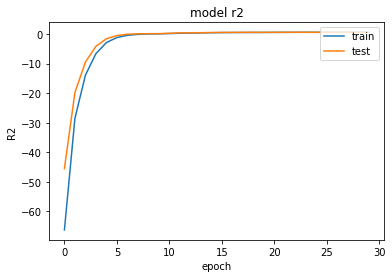

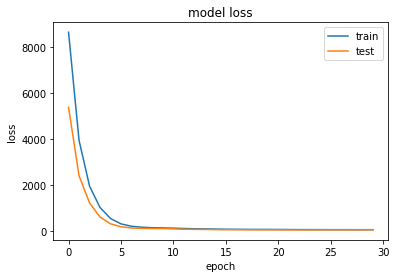

4209/4209 [==============================] - 11s 3ms/step


In [39]:
model=coordinate(ss_train,y_train)
predict(ss_test,model)

LB(0.52588,0.52741),CV:.5835

**GridSearch for NN**

In [0]:
#https://stackoverflow.com/questions/48390601/explicitly-specifying-test-train-sets-in-gridsearchcv
from sklearn.model_selection import PredefinedSplit
train_indices = np.full((3368,), -1, dtype=int)
test_indices = np.full((841,), 0, dtype=int)
test_fold = np.append(train_indices, test_indices)
#.2 split
np.random.shuffle(test_fold)#shuffling of array done here
ps = PredefinedSplit(test_fold)

In [24]:
net=KerasRegressor(build_fn= simple_net,verbose=False,epochs=30)

dropout_rate = [0.1, 0.2, 0.3, 0.4, ]
init = ['glorot_uniform', 'normal', 'uniform']
act=['tanh','relu']
batches = [5, 10, 20]
param_grid = dict(dropout=dropout_rate, 
                  batch_size=batches, 
                  act_func= act,
                  init=init)

grid = GridSearchCV(estimator=net, param_grid=param_grid,cv=ps,verbose=2,n_jobs=-1,scoring='r2')
grid_result = grid.fit(ss_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 1 folds for each of 72 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 105.6min finished


Best: 0.565752 using {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.4, 'init': 'glorot_uniform'}
0.556514 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.1, 'init': 'glorot_uniform'}
0.557950 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.1, 'init': 'normal'}
0.550767 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.1, 'init': 'uniform'}
0.563773 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.2, 'init': 'glorot_uniform'}
0.555549 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.2, 'init': 'normal'}
0.551606 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.2, 'init': 'uniform'}
0.550896 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.3, 'init': 'glorot_uniform'}
0.562173 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.3, 'init': 'normal'}
0.552852 (0.000000) with: {'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.3, 'init': '

**Fitting the best NN model according to Gridsearch**

In [0]:
#gridsearch best params
best={'act_func': 'tanh', 'batch_size': 5, 'dropout': 0.4, 'init': 'glorot_uniform'}
net=KerasRegressor(build_fn= simple_net,verbose=False,epochs=30,**best)
net.fit(ss_train,y_train)
subm = pd.DataFrame()
subm['ID'] =test.ID
subm['y'] = net.predict(ss_test)
subm.to_csv('NN_final.csv', index=False)

LB(0.53706,0.55288),CV:.5657

**Storing the Best Model So Far**

In [0]:
pkl_filename = "/content/drive/My Drive/mercedes-benz-greener-manufacturing/pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(stack, file)

### **Inference**

In [0]:
pkl_filename = "/content/drive/My Drive/mercedes-benz-greener-manufacturing/pickle_model.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

[14:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
test= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/test_label.csv')
train= pd.read_csv('/content/drive/My Drive/mercedes-benz-greener-manufacturing/train_label.csv')

y_train= train.y.values
targets= y_train
train.drop(['y'],inplace= True,axis=1)

In [0]:
x_test= np.array(test)
ids_test= test.ID
y_pred = pickle_model.predict(x_test)
subm = pd.DataFrame()
subm['ID'] = ids_test
subm['y'] = y_pred
subm.to_csv('pickle_submission.csv', index=False)

### **Conclusion**

In [34]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Categorical_encoding",'CV', "PublicLB","PrivateLB"]
x.add_row(["XGB_pca",'label',.5972, .5615,.5463])
x.add_row(["LinearReg",'one_hot',.5830, .5325,.5378])
x.add_row(["LinearReg",'mean/tar',.5838, .5438,.5379])
x.add_row(["RandomForest",'mean/tar',.6055, .5586,.5489])
x.add_row(["XGboost",'mean/tar',.6081, .5570,.5483])
x.add_row(["ExtraTrees",'mean/tar',.6009, .5554,.5483])
x.add_row(["RandomForest",'label',.6023, .5568,.5498])
x.add_row(["XGboost",'label',.6042, .5555,.5503])
x.add_row(["ExtraTrees",'label',.5986, .5537,.5470])
x.add_row(["***Stacked(et,rf,xgb)***",'label',.6052, .5579,.5522])
x.add_row(["Stack+interactions(et,rf,xgb)",'label',.6044, .5573,.5519])
x.add_row(['SVR+TSVD','one_hot',.5567,.5157,.5021])
x.add_row(['SVR+selectKBest','one_hot',.5639,.5167,.5079])
x.add_row(['NeuralNet','one_hot',.5657,0.5528,0.5370])
print(x)

+-------------------------------+----------------------+--------+----------+-----------+
|             Model             | Categorical_encoding |   CV   | PublicLB | PrivateLB |
+-------------------------------+----------------------+--------+----------+-----------+
|            XGB_pca            |        label         | 0.5972 |  0.5615  |   0.5463  |
|           LinearReg           |       one_hot        | 0.583  |  0.5325  |   0.5378  |
|           LinearReg           |       mean/tar       | 0.5838 |  0.5438  |   0.5379  |
|          RandomForest         |       mean/tar       | 0.6055 |  0.5586  |   0.5489  |
|            XGboost            |       mean/tar       | 0.6081 |  0.557   |   0.5483  |
|           ExtraTrees          |       mean/tar       | 0.6009 |  0.5554  |   0.5483  |
|          RandomForest         |        label         | 0.6023 |  0.5568  |   0.5498  |
|            XGboost            |        label         | 0.6042 |  0.5555  |   0.5503  |
|           ExtraTree

### **Overview of the Project** 
**DataExploration observations**

369columns ,4209 rows,no missing values present
There are 20-25 outliers,duplicate rows,along with columns present.Correlation between some features is really high,Pca seems to be of some Importance.

**DataPreperation**

Removal of features with <.01 variance,clipping of outliers to 150,dataset with label encoding ,one-hot,mean encoding of categorical variables done.

**Modelling**

CV used was of 15 folds with 5 fold,3 repeats
random_seed with 3 used throughout for reproducibility.

1.   Baseline was with 12 pca components appended to label encoded datasetwith xgboost on top, averaging of 15 cv models is done along with one trained on whole dataset.
2.   LinearRegression with one-hot encoding and mean enconding done.
t-test was used to check on cv folds whether ID feature really made any statistical significance on CV folds or not. Found out it doesen't.
3.   Mean encoding was done on RandomForestRegressor,XGBRegressor,ExtraTreesRegressor with their respective hyperparameter tuning.
4.   Label encoding dataset used with all the three models with tuning(RF,XGB,ExtraTrees)
5.   Stacking done on above tree based models with a ridge Regressor on top.
6.   New features are tried based on their Spearman correlation with the target variable. 

7.   Linear SVR and kernel SVR are modelled on one_hot encoding, here to reduce dimensionality TSVD and SelectKBest, both were tried out.
8.   Bayesian  Optimization library has been used to further finely tune the tree based models. 
7.   A Deeplearning model with a simple architecture has  been created on the one-hot encoded dataset. 
8.   Storing the best model of all the above.
7.   Checking for reproducibility of results.
8.   Conclusion with pretty table with PublicLB,PrivateLB,CV scores of above mentioned models.






